# Insurance Dataset Exploration and Analysis

This notebook explores real insurance datasets from Kaggle to understand their structure, quality, and characteristics for fine-tuning an AI Insurance Assistant.

## Objectives
- Download and load real insurance datasets from Kaggle
- Analyze data quality and distribution
- Preprocess data for model training
- Visualize dataset characteristics
- Prepare datasets for fine-tuning

## 1. Environment Setup and Kaggle Configuration

First, let's set up the environment and configure Kaggle API access.

In [1]:
# Install required packages with proper versions
!pip install --upgrade pip
!pip install nbformat>=4.2.0 ipywidgets
!pip install kaggle pandas numpy matplotlib seaborn plotly wordcloud scikit-learn datasets transformers

# Core data manipulation and analysis
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
import warnings
import zipfile
import requests
warnings.filterwarnings('ignore')

# Handle nbformat issue for display functionality
try:
    from IPython.display import display, HTML
    DISPLAY_AVAILABLE = True
except ImportError:
    print("⚠️ IPython display not available - using print instead")
    DISPLAY_AVAILABLE = False
    def display(obj):
        print(obj)

# Kaggle API
try:
    import kaggle
    from kaggle.api.kaggle_api_extended import KaggleApi
    KAGGLE_IMPORT_SUCCESS = True
except ImportError:
    print("⚠️ Kaggle package not found - will install")
    !pip install kaggle
    import kaggle
    from kaggle.api.kaggle_api_extended import KaggleApi
    KAGGLE_IMPORT_SUCCESS = True

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Text analysis
from collections import Counter
import re
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    print("⚠️ WordCloud not available - will skip word cloud generation")
    WORDCLOUD_AVAILABLE = False

# Machine learning utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Set up matplotlib and seaborn styling
plt.style.use('default')
sns.set_palette("husl")

print("✅ All dependencies imported successfully!")
print(f"📊 Display available: {DISPLAY_AVAILABLE}")
print(f"☁️ WordCloud available: {WORDCLOUD_AVAILABLE}")
print(f"📈 Kaggle API available: {KAGGLE_IMPORT_SUCCESS}")

  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
D:\git_projects\machine-learning\ai-insurance-assistant\.venv\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ All dependencies imported successfully!
📊 Display available: True
☁️ WordCloud available: True
📈 Kaggle API available: True


In [2]:
# Configure Kaggle API
# SETUP INSTRUCTIONS:
# 1. Go to https://www.kaggle.com/settings
# 2. Scroll down to API section
# 3. Click "Create New API Token" to download kaggle.json
# 4. Place kaggle.json in one of these locations:
#    - Windows: C:\Users\{username}\.kaggle\kaggle.json
#    - Linux/Mac: ~/.kaggle/kaggle.json
# 5. Make sure the file has proper permissions (chmod 600 on Linux/Mac)

import os

def setup_kaggle_api():
    """Setup Kaggle API with proper error handling and instructions."""
    try:
        # Try to authenticate
        api = KaggleApi()
        api.authenticate()
        print("✅ Kaggle API authenticated successfully!")
        print("📝 Make sure you have accepted the rules for each dataset you want to download")
        return api
    except OSError as e:
        print("❌ Kaggle API setup required!")
        print("\n🔧 SETUP INSTRUCTIONS:")
        print("1. Go to https://www.kaggle.com/settings")
        print("2. Scroll to 'API' section")
        print("3. Click 'Create New API Token' to download kaggle.json")
        print("4. Place the file at: C:\\Users\\wasif\\.kaggle\\kaggle.json")
        print("5. Create the .kaggle directory if it doesn't exist")
        print("\n💻 Quick setup commands:")
        print("mkdir C:\\Users\\wasif\\.kaggle")
        print("# Then move your downloaded kaggle.json to that folder")
        print("\n⚠️ Alternative: Set environment variables:")
        print("$env:KAGGLE_USERNAME='your-username'")
        print("$env:KAGGLE_KEY='your-api-key'")
        print("\n🔄 For now, we'll use alternative data sources...")
        return None
    except Exception as e:
        print(f"❌ Unexpected error: {str(e)}")
        print("🔄 Continuing with alternative data sources...")
        return None

# Setup Kaggle API
api = setup_kaggle_api()
KAGGLE_AVAILABLE = api is not None

✅ Kaggle API authenticated successfully!
📝 Make sure you have accepted the rules for each dataset you want to download


## 2. Download Real Insurance Datasets from Kaggle

Let's download several insurance-related datasets from Kaggle.

In [3]:
# Define data paths with enhanced organization
DATA_DIR = Path("../data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

# Create organized subdirectories in raw folder
KAGGLE_DATA_DIR = RAW_DATA_DIR / "kaggle"
PUBLIC_DATA_DIR = RAW_DATA_DIR / "public"
SYNTHETIC_DATA_DIR = RAW_DATA_DIR / "synthetic"

# Ensure all directories exist
for dir_path in [RAW_DATA_DIR, PROCESSED_DATA_DIR, KAGGLE_DATA_DIR, PUBLIC_DATA_DIR, SYNTHETIC_DATA_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"📁 Created data directory structure:")
print(f"  {RAW_DATA_DIR}")
print(f"  ├── kaggle/       # Kaggle datasets")
print(f"  ├── public/       # Public datasets from URLs")
print(f"  └── synthetic/    # Generated datasets")
print(f"  {PROCESSED_DATA_DIR}    # Cleaned & processed data")

# Enhanced list of alternative data sources (publicly available)
alternative_datasets = [
    {
        'name': 'insurance_sample',
        'url': 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv',
        'description': 'Medical Cost Personal Dataset',
        'filename': 'insurance_medical_cost.csv',
        'category': 'health_insurance'
    },
    {
        'name': 'auto_insurance_claims',
        'url': 'https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/auto-insurance-claims-data.csv',
        'description': 'Auto Insurance Claims Dataset',
        'filename': 'auto_insurance_claims.csv',
        'category': 'auto_insurance'
    }
]

def download_from_url(url, filename, description, category):
    """Download dataset from direct URL with enhanced organization."""
    try:
        print(f"📥 Downloading {description}...")
        import urllib.request
        
        # Organize by category in public folder
        category_dir = PUBLIC_DATA_DIR / category
        category_dir.mkdir(exist_ok=True)
        
        file_path = category_dir / filename
        urllib.request.urlretrieve(url, file_path)
        print(f"✅ Downloaded {filename} to {file_path.relative_to(DATA_DIR)}")
        return file_path
    except Exception as e:
        print(f"❌ Error downloading {filename}: {str(e)}")
        return None

# Download alternative datasets with better organization
downloaded_files = []
print("\n🌐 Downloading public datasets...")
for dataset in alternative_datasets:
    file_path = download_from_url(
        dataset['url'], 
        dataset['filename'], 
        dataset['description'],
        dataset['category']
    )
    if file_path:
        downloaded_files.append({
            'name': dataset['name'],
            'path': file_path,
            'description': dataset['description'],
            'source': 'public_url',
            'category': dataset['category']
        })

# Enhanced Kaggle datasets with more comprehensive insurance data
kaggle_datasets = [
    {
        'name': 'mirichoi0218/insurance',
        'description': 'Medical Cost Personal Dataset',
        'files': ['insurance.csv'],
        'category': 'health_insurance'
    },
    {
        'name': 'datacertlaboratoire/health-insurance-cross-sell-prediction',
        'description': 'Health Insurance Cross Sell Prediction',
        'files': ['train.csv', 'test.csv'],
        'category': 'health_insurance'
    },
    {
        'name': 'anmolkumar/health-insurance-cross-sell-prediction',
        'description': 'Vehicle Insurance Dataset',
        'files': ['train.csv'],
        'category': 'vehicle_insurance'
    },
    {
        'name': 'ifteshanalom/vehicle-insurance-customer-data',
        'description': 'Vehicle Insurance Customer Data',
        'files': ['vehicle_insurance_customer_data.csv'],
        'category': 'vehicle_insurance'
    },
    {
        'name': 'tejashvi14/insurance-premium-prediction',
        'description': 'Insurance Premium Prediction Dataset',
        'files': ['insurance_premium_prediction.csv'],
        'category': 'premium_prediction'
    },
    {
        'name': 'noordeen/insurance-premium-prediction',
        'description': 'Insurance Premium Analysis',
        'files': ['insurance.csv'],
        'category': 'premium_prediction'
    },
    {
        'name': 'thedevastator/insurance-claim-analysis-demographic-and-health',
        'description': 'Insurance Claim Analysis Dataset',
        'files': ['insurance_claims.csv'],
        'category': 'claims_analysis'
    }
]

def download_kaggle_dataset(dataset_name, download_path, category):
    """Download dataset from Kaggle with enhanced organization."""
    if not KAGGLE_AVAILABLE:
        print(f"⏭️ Skipping Kaggle dataset {dataset_name} (API not configured)")
        return False
    
    try:
        print(f"📥 Downloading {dataset_name} from Kaggle...")
        
        # Create category subdirectory
        category_path = download_path / category
        category_path.mkdir(exist_ok=True)
        
        api.dataset_download_files(dataset_name, path=category_path, unzip=True)
        print(f"✅ Downloaded {dataset_name} to {category_path.relative_to(DATA_DIR)}")
        return True
    except Exception as e:
        print(f"❌ Error downloading {dataset_name}: {str(e)}")
        return False

# Download Kaggle datasets if API is available
downloaded_datasets = []
if KAGGLE_AVAILABLE:
    print("\n🎯 Downloading datasets from Kaggle...")
    for dataset in kaggle_datasets:
        success = download_kaggle_dataset(
            dataset['name'], 
            KAGGLE_DATA_DIR, 
            dataset['category']
        )
        
        if success:
            # Find downloaded files
            category_path = KAGGLE_DATA_DIR / dataset['category']
            for file_pattern in dataset['files']:
                matching_files = list(category_path.glob(f"**/{file_pattern}"))
                for file_path in matching_files:
                    downloaded_datasets.append({
                        'name': dataset['name'],
                        'path': file_path,
                        'description': f"{dataset['description']} - {file_path.name}",
                        'source': 'kaggle',
                        'category': dataset['category']
                    })
else:
    print("\n⚠️ Kaggle API not available. Using alternative data sources.")
    print("💡 To enable Kaggle downloads, configure your API credentials.")

# Combine all downloaded datasets
all_datasets = downloaded_files + downloaded_datasets
print(f"\n🎉 Successfully downloaded {len(all_datasets)} datasets!")

# Group datasets by category for better organization
datasets_by_category = {}
for dataset in all_datasets:
    category = dataset.get('category', 'uncategorized')
    if category not in datasets_by_category:
        datasets_by_category[category] = []
    datasets_by_category[category].append(dataset)

print(f"\n📊 Datasets organized by category:")
for category, datasets in datasets_by_category.items():
    print(f"  🏷️ {category.replace('_', ' ').title()}: {len(datasets)} datasets")
    for dataset in datasets:
        source_icon = "🔗" if dataset['source'] == 'public_url' else "📊"
        print(f"    {source_icon} {dataset['description']}")

# Create enhanced synthetic insurance data
def create_enhanced_synthetic_data():
    """Create comprehensive synthetic insurance Q&A data with multiple categories."""
    
    # Enhanced synthetic Q&A data covering more insurance domains
    synthetic_qa = [
        # Health Insurance
        {
            "question": "What is comprehensive health insurance coverage?",
            "answer": "Comprehensive health insurance coverage includes medical, surgical, and hospital expenses. It typically covers preventive care, emergency services, prescription drugs, mental health services, and specialized treatments. Most plans also include coverage for pre-existing conditions under the Affordable Care Act.",
            "category": "health_insurance",
            "difficulty": "basic",
            "source": "synthetic_expert",
            "keywords": ["health", "coverage", "medical", "preventive", "emergency"]
        },
        {
            "question": "How do health insurance deductibles work?",
            "answer": "A health insurance deductible is the amount you pay for covered health care services before your insurance plan starts to pay. For example, with a $1,000 deductible, you pay the first $1,000 of covered services yourself. After meeting your deductible, you typically pay only a copayment or coinsurance for covered services.",
            "category": "health_insurance", 
            "difficulty": "intermediate",
            "source": "synthetic_expert",
            "keywords": ["deductible", "copayment", "coinsurance", "covered services"]
        },
        
        # Auto Insurance
        {
            "question": "What is comprehensive auto insurance coverage?",
            "answer": "Comprehensive auto insurance coverage protects your vehicle against damages not caused by collisions, such as theft, vandalism, natural disasters, falling objects, and animal strikes. It typically covers repairs or replacement of your vehicle minus your deductible. This coverage is optional but recommended for newer or valuable vehicles.",
            "category": "auto_insurance",
            "difficulty": "basic",
            "source": "synthetic_expert",
            "keywords": ["comprehensive", "auto", "theft", "vandalism", "collision"]
        },
        {
            "question": "What factors affect auto insurance premiums?",
            "answer": "Auto insurance premiums are influenced by multiple factors: your driving record and experience, age and gender, vehicle make and model, location and garaging address, annual mileage, coverage types and limits, deductible amounts, credit score, and claims history. Insurance companies use these factors to assess risk and determine pricing.",
            "category": "auto_insurance",
            "difficulty": "intermediate", 
            "source": "synthetic_expert",
            "keywords": ["premiums", "driving record", "vehicle", "coverage limits", "risk assessment"]
        },
        
        # Life Insurance
        {
            "question": "What is the difference between term and whole life insurance?",
            "answer": "Term life insurance provides coverage for a specific period (10, 20, or 30 years) at lower premiums but has no cash value. Whole life insurance provides lifelong coverage with higher premiums but builds cash value that can be borrowed against. Term is cheaper and simpler; whole life combines insurance with investment components.",
            "category": "life_insurance",
            "difficulty": "basic",
            "source": "synthetic_expert",
            "keywords": ["term life", "whole life", "cash value", "premiums", "coverage period"]
        },
        {
            "question": "How do I file a life insurance claim?",
            "answer": "To file a life insurance claim: 1) Contact the insurance company immediately after the policyholder's death, 2) Obtain multiple certified copies of the death certificate, 3) Complete the claim forms provided by the insurer, 4) Submit required documentation including policy information and beneficiary identification, 5) Wait for the claim review process, which typically takes 30-60 days for approval.",
            "category": "life_insurance",
            "difficulty": "intermediate",
            "source": "synthetic_expert",
            "keywords": ["claim filing", "death certificate", "beneficiary", "policy", "claim review"]
        },
        
        # Home Insurance
        {
            "question": "What does homeowners insurance typically cover?",
            "answer": "Homeowners insurance typically covers: dwelling protection (structure of your home), personal property, liability protection, additional living expenses if your home becomes uninhabitable, other structures on your property like garages or sheds, and medical payments for injured guests. Coverage varies by policy type and location.",
            "category": "home_insurance",
            "difficulty": "basic",
            "source": "synthetic_expert",
            "keywords": ["dwelling", "personal property", "liability", "living expenses", "medical payments"]
        },
        {
            "question": "What factors affect homeowners insurance premiums?",
            "answer": "Homeowners insurance premiums are affected by: location and local crime rates, home age and construction materials, coverage amount and deductibles, personal credit score, claims history, proximity to fire stations and water sources, roof condition, security systems, and additional coverage options like flood or earthquake insurance.",
            "category": "home_insurance",
            "difficulty": "intermediate",
            "source": "synthetic_expert",
            "keywords": ["location", "construction", "credit score", "claims history", "security systems"]
        },
        
        # Business Insurance
        {
            "question": "What is general liability insurance for businesses?",
            "answer": "General liability insurance protects businesses against claims of bodily injury, property damage, and personal/advertising injury caused by business operations, products, or services. It covers legal costs, medical expenses, and settlement amounts. This insurance is essential for most businesses and often required by landlords and clients.",
            "category": "business_insurance",
            "difficulty": "basic",
            "source": "synthetic_expert",
            "keywords": ["liability", "bodily injury", "property damage", "legal costs", "business operations"]
        },
        {
            "question": "What is professional liability insurance?",
            "answer": "Professional liability insurance, also called errors and omissions (E&O) insurance, protects professionals against claims of negligence, errors, or omissions in their professional services. It covers legal defense costs, damages, and settlements. This coverage is crucial for consultants, lawyers, doctors, architects, and other service professionals.",
            "category": "business_insurance",
            "difficulty": "intermediate",
            "source": "synthetic_expert",
            "keywords": ["professional liability", "errors omissions", "negligence", "professional services", "legal defense"]
        },
        
        # General Insurance Concepts
        {
            "question": "What is a deductible and how does it work?",
            "answer": "A deductible is the amount you pay out-of-pocket before your insurance coverage begins. For example, with a $500 deductible, you pay the first $500 of covered damages, and insurance pays the rest. Higher deductibles typically mean lower premium costs but more upfront expenses when filing a claim.",
            "category": "general_insurance",
            "difficulty": "basic",
            "source": "synthetic_expert",
            "keywords": ["deductible", "out-of-pocket", "premiums", "covered damages", "claim"]
        },
        {
            "question": "How do insurance companies determine risk and pricing?",
            "answer": "Insurance companies determine risk through statistical analysis and actuarial science. They consider factors like age, location, health status, driving record, credit score, claims history, and industry-specific risks. This risk assessment helps them set appropriate premiums and coverage terms to maintain profitability while providing adequate coverage to policyholders.",
            "category": "general_insurance",
            "difficulty": "advanced",
            "source": "synthetic_expert",
            "keywords": ["risk assessment", "actuarial", "statistical analysis", "premiums", "profitability"]
        },
        
        # Claims Process
        {
            "question": "What is the typical insurance claims process?",
            "answer": "The insurance claims process typically involves: 1) Reporting the incident to your insurance company promptly, 2) Providing detailed information and documentation, 3) Insurance adjuster investigation and assessment, 4) Damage evaluation and estimate, 5) Coverage determination based on policy terms, 6) Settlement negotiation if applicable, 7) Payment processing and claim closure.",
            "category": "claims_process",
            "difficulty": "intermediate",
            "source": "synthetic_expert",
            "keywords": ["claims process", "adjuster", "investigation", "settlement", "policy terms"]
        },
        
        # Specialty Insurance
        {
            "question": "Do I need umbrella insurance?",
            "answer": "Umbrella insurance provides additional liability coverage beyond your standard auto and homeowners policies. Consider it if you have significant assets to protect, engage in high-risk activities, employ domestic workers, or want extra protection against large lawsuits. It's relatively inexpensive for the coverage amount and can protect against judgments that exceed your primary policy limits.",
            "category": "specialty_insurance",
            "difficulty": "intermediate",
            "source": "synthetic_expert",
            "keywords": ["umbrella insurance", "liability coverage", "assets", "lawsuit protection", "policy limits"]
        }
    ]
    
    # Save enhanced synthetic data
    synthetic_path = SYNTHETIC_DATA_DIR / "enhanced_insurance_qa.json"
    with open(synthetic_path, 'w', encoding='utf-8') as f:
        json.dump(synthetic_qa, f, indent=2, ensure_ascii=False)
    
    print(f"📝 Created {len(synthetic_qa)} enhanced synthetic Q&A pairs")
    print(f"💾 Saved to: {synthetic_path.relative_to(DATA_DIR)}")
    
    # Create category-specific files
    categories = {}
    for qa in synthetic_qa:
        category = qa['category']
        if category not in categories:
            categories[category] = []
        categories[category].append(qa)
    
    # Save category-specific files
    for category, qa_list in categories.items():
        category_file = SYNTHETIC_DATA_DIR / f"{category}_qa.json"
        with open(category_file, 'w', encoding='utf-8') as f:
            json.dump(qa_list, f, indent=2, ensure_ascii=False)
        print(f"  📄 {category}: {len(qa_list)} Q&A pairs → {category_file.name}")
    
    return synthetic_qa, synthetic_path, categories

# Create enhanced synthetic data
synthetic_qa, synthetic_path, synthetic_categories = create_enhanced_synthetic_data()

print(f"\n✨ Enhanced data collection completed:")
print(f"  📊 Real datasets: {len(all_datasets)}")
print(f"  📝 Synthetic Q&A pairs: {len(synthetic_qa)}")
print(f"  🏷️ Insurance categories: {len(synthetic_categories)}")
print(f"  🎯 Total data sources: {len(all_datasets) + len(synthetic_categories)}")

# Save dataset inventory
inventory = {
    'real_datasets': all_datasets,
    'synthetic_categories': list(synthetic_categories.keys()),
    'download_timestamp': pd.Timestamp.now().isoformat(),
    'total_files': len(all_datasets) + len(synthetic_categories)
}

inventory_path = RAW_DATA_DIR / "dataset_inventory.json"
with open(inventory_path, 'w', encoding='utf-8') as f:
    json.dump(inventory, f, indent=2, ensure_ascii=False, default=str)

print(f"📋 Dataset inventory saved to: {inventory_path.relative_to(DATA_DIR)}")

📁 Created data directory structure:
  ..\data\raw
  ├── kaggle/       # Kaggle datasets
  ├── public/       # Public datasets from URLs
  └── synthetic/    # Generated datasets
  ..\data\processed    # Cleaned & processed data

🌐 Downloading public datasets...
📥 Downloading Medical Cost Personal Dataset...
✅ Downloaded insurance_medical_cost.csv to raw\public\health_insurance\insurance_medical_cost.csv
📥 Downloading Auto Insurance Claims Dataset...
❌ Error downloading auto_insurance_claims.csv: HTTP Error 404: Not Found

🎯 Downloading datasets from Kaggle...
📥 Downloading mirichoi0218/insurance from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/mirichoi0218/insurance
✅ Downloaded mirichoi0218/insurance to raw\kaggle\health_insurance
📥 Downloading datacertlaboratoire/health-insurance-cross-sell-prediction from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/datacertlaboratoire/health-insurance-cross-sell-prediction
❌ Error downloading datacertlaboratoire/health-insurance

In [4]:
# Data Exploration and Analysis

def explore_csv_data(file_path, name):
    """Explore and visualize CSV data."""
    try:
        df = pd.read_csv(file_path)
        print(f"\n📊 Dataset: {name}")
        print(f"📁 File: {file_path}")
        print(f"📏 Shape: {df.shape}")
        
        # Display basic info
        print("\n🔍 Column Information:")
        print(df.info())
        
        print("\n📈 Basic Statistics:")
        print(df.describe())
        
        print("\n🎯 Sample Data:")
        print(df.head())
        
        # Check for missing values
        missing = df.isnull().sum()
        if missing.any():
            print("\n⚠️ Missing Values:")
            print(missing[missing > 0])
        
        # Visualizations for numeric columns
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        if len(numeric_columns) > 0:
            fig = make_subplots(
                rows=min(2, len(numeric_columns)),
                cols=min(2, max(1, len(numeric_columns)//2)),
                subplot_titles=numeric_columns[:4]
            )
            
            for i, col in enumerate(numeric_columns[:4]):
                row = i // 2 + 1
                col_pos = i % 2 + 1
                fig.add_trace(
                    go.Histogram(x=df[col], name=col, showlegend=False),
                    row=row, col=col_pos
                )
            
            fig.update_layout(
                title=f"Numeric Distributions - {name}",
                height=600
            )
            fig.show()
        
        # Categorical analysis
        categorical_columns = df.select_dtypes(include=['object']).columns
        if len(categorical_columns) > 0:
            print(f"\n📊 Categorical Columns ({len(categorical_columns)}):")
            for col in categorical_columns[:5]:  # Limit to first 5
                unique_count = df[col].nunique()
                print(f"  {col}: {unique_count} unique values")
                if unique_count <= 10:
                    print(f"    Values: {df[col].unique()[:10]}")
        
        return df
    
    except Exception as e:
        print(f"❌ Error exploring {file_path}: {str(e)}")
        return None

# Explore all downloaded datasets
datasets_info = {}
print("🔍 Exploring all available datasets...\n")

# Explore alternative datasets
for dataset in downloaded_files:
    df = explore_csv_data(dataset['path'], dataset['description'])
    if df is not None:
        datasets_info[dataset['name']] = {
            'dataframe': df,
            'info': dataset
        }

# Explore Kaggle datasets
for dataset in downloaded_datasets:
    dataset_path = dataset['path']
    # Look for CSV files in the dataset directory
    csv_files = list(dataset_path.glob("*.csv"))
    for csv_file in csv_files:
        df = explore_csv_data(csv_file, f"{dataset['description']} - {csv_file.name}")
        if df is not None:
            key = f"{dataset['name']}_{csv_file.stem}"
            datasets_info[key] = {
                'dataframe': df,
                'info': {**dataset, 'file': csv_file.name}
            }

🔍 Exploring all available datasets...


📊 Dataset: Medical Cost Personal Dataset
📁 File: ..\data\raw\public\health_insurance\insurance_medical_cost.csv
📏 Shape: (1338, 7)

🔍 Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

📈 Basic Statistics:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15


📊 Categorical Columns (3):
  sex: 2 unique values
    Values: ['female' 'male']
  smoker: 2 unique values
    Values: ['yes' 'no']
  region: 4 unique values
    Values: ['southwest' 'southeast' 'northwest' 'northeast']


In [5]:
# Optimized Synthetic Q&A Data Analysis (Fast Version)
import time
start_time = time.time()

# Check if required variables exist
try:
    PLOTLY_AVAILABLE = 'make_subplots' in globals() and 'go' in globals()
except:
    PLOTLY_AVAILABLE = False

synthetic_path = RAW_DATA_DIR / "synthetic_insurance_qa.json"

if synthetic_path.exists():
    print("🤖 Synthetic Insurance Q&A Data Analysis")
    print(f"📁 File: {synthetic_path.relative_to(DATA_DIR)}")
    
    try:
        # Load synthetic data efficiently
        with open(synthetic_path, 'r', encoding='utf-8') as f:
            synthetic_qa = json.load(f)
        
        # Quick validation
        if not synthetic_qa or not isinstance(synthetic_qa, list):
            print("❌ Invalid synthetic data format")
        else:
            # Convert to DataFrame for analysis
            qa_df = pd.DataFrame(synthetic_qa)
            
            print(f"📊 Total Q&A pairs: {len(qa_df)}")
            print(f"📏 DataFrame shape: {qa_df.shape}")
            print(f"🔍 Columns: {list(qa_df.columns)}")
            
            # Quick statistics
            if 'category' in qa_df.columns:
                category_counts = qa_df['category'].value_counts()
                print(f"\n📊 Category Distribution:")
                print(category_counts)
            
            if 'difficulty' in qa_df.columns:
                difficulty_counts = qa_df['difficulty'].value_counts()
                print(f"\n🎯 Difficulty Distribution:")
                print(difficulty_counts)
            
            # Text length analysis (optimized)
            qa_df['question_length'] = qa_df['question'].str.len()
            qa_df['answer_length'] = qa_df['answer'].str.len()
            
            print(f"\n📏 Text Length Statistics:")
            print(f"Questions - Min: {qa_df['question_length'].min()}, Max: {qa_df['question_length'].max()}, Avg: {qa_df['question_length'].mean():.1f}")
            print(f"Answers - Min: {qa_df['answer_length'].min()}, Max: {qa_df['answer_length'].max()}, Avg: {qa_df['answer_length'].mean():.1f}")
            
            # Simple text-based visualization (fast)
            print("\n📊 Quick Category Overview:")
            if 'category' in qa_df.columns:
                for category, count in category_counts.head(5).items():
                    percentage = (count / len(qa_df)) * 100
                    bar = "█" * min(int(percentage), 20)  # Limit bar length
                    print(f"  {category:<20} {bar} {count} ({percentage:.1f}%)")
            
            # Sample Q&A (limited for speed)
            print(f"\n📝 Sample Q&A pairs:")
            if 'category' in qa_df.columns:
                for i, category in enumerate(qa_df['category'].unique()[:2]):  # Only 2 categories
                    sample = qa_df[qa_df['category'] == category].iloc[0]
                    print(f"\n🏷️ {category}:")
                    print(f"❓ Q: {sample['question']}")
                    print(f"💡 A: {sample['answer'][:100]}...")
            
            # Optional: Create simple visualization only if explicitly requested
            create_viz = False  # Set to True if you want visualization
            if create_viz and PLOTLY_AVAILABLE:
                try:
                    print(f"\n📈 Creating visualization...")
                    # Simple single chart instead of complex subplots
                    import plotly.express as px
                    
                    if 'category' in qa_df.columns:
                        fig = px.bar(
                            x=category_counts.index, 
                            y=category_counts.values,
                            title="Category Distribution",
                            labels={'x': 'Category', 'y': 'Count'}
                        )
                        fig.show()
                        print("✅ Visualization created successfully")
                except Exception as e:
                    print(f"⚠️ Visualization failed: {e}")
            
            elapsed = time.time() - start_time
            print(f"\n⚡ Analysis completed in {elapsed:.2f} seconds")
            
    except Exception as e:
        print(f"❌ Error processing synthetic data: {e}")
        
else:
    print("❌ Synthetic Q&A file not found.")
    print(f"Expected location: {synthetic_path}")
    print("💡 Run the data download cell first to create synthetic data")

# Clean up
if 'start_time' in locals():
    del start_time

🤖 Synthetic Insurance Q&A Data Analysis
📁 File: raw\synthetic_insurance_qa.json
📊 Total Q&A pairs: 8
📏 DataFrame shape: (8, 5)
🔍 Columns: ['question', 'answer', 'category', 'difficulty', 'source']

📊 Category Distribution:
category
life_insurance         2
general_insurance      2
auto_insurance         1
home_insurance         1
health_insurance       1
liability_insurance    1
Name: count, dtype: int64

🎯 Difficulty Distribution:
difficulty
basic           3
intermediate    3
advanced        2
Name: count, dtype: int64

📏 Text Length Statistics:
Questions - Min: 29, Max: 61, Avg: 44.2
Answers - Min: 265, Max: 349, Avg: 314.1

📊 Quick Category Overview:
  life_insurance       ████████████████████ 2 (25.0%)
  general_insurance    ████████████████████ 2 (25.0%)
  auto_insurance       ████████████ 1 (12.5%)
  home_insurance       ████████████ 1 (12.5%)
  health_insurance     ████████████ 1 (12.5%)

📝 Sample Q&A pairs:

🏷️ auto_insurance:
❓ Q: What is comprehensive auto insurance coverage

## 3. Alternative: Download Insurance QA Dataset

Let's also download the popular Insurance QA dataset for question-answering tasks.

In [6]:
# Download Insurance QA dataset from GitHub
def download_insurance_qa():
    """Download Insurance QA dataset from GitHub."""
    import urllib.request
    
    qa_dir = RAW_DATA_DIR / "insurance_qa"
    qa_dir.mkdir(exist_ok=True)
    
    # URLs for Insurance QA dataset files
    base_url = "https://raw.githubusercontent.com/shuzi/insuranceQA/master/V1"
    files_to_download = [
        "question.train.token_idx.label",
        "question.test1.label.token_idx.pool",
        "question.test2.label.token_idx.pool",
        "answers.label.token_idx",
        "vocabulary"
    ]
    
    try:
        for file_name in files_to_download:
            url = f"{base_url}/{file_name}"
            file_path = qa_dir / file_name
            
            print(f"📥 Downloading {file_name}...")
            urllib.request.urlretrieve(url, file_path)
        
        print("✅ Insurance QA dataset downloaded successfully!")
        return qa_dir
    except Exception as e:
        print(f"❌ Error downloading Insurance QA: {str(e)}")
        return None

# Download Insurance QA
qa_dataset_path = download_insurance_qa()

📥 Downloading question.train.token_idx.label...
📥 Downloading question.test1.label.token_idx.pool...
📥 Downloading question.test2.label.token_idx.pool...
📥 Downloading answers.label.token_idx...
📥 Downloading vocabulary...
✅ Insurance QA dataset downloaded successfully!


## 4. Load and Explore Downloaded Datasets

Now let's load and explore the real datasets we've downloaded.

In [7]:
# Enhanced Dataset Exploration Functions

class InsuranceDataExplorer:
    """Comprehensive insurance dataset exploration class."""
    
    def __init__(self, display_available=True):
        self.display_available = display_available
        self.datasets = {}
        self.exploration_results = {}
    
    def load_csv_dataset(self, file_path, dataset_name, category=None):
        """Load and provide comprehensive exploration of CSV dataset."""
        try:
            df = pd.read_csv(file_path)
            
            print(f"\n📊 Dataset: {dataset_name}")
            print("="*70)
            print(f"📁 File: {file_path.relative_to(DATA_DIR) if isinstance(file_path, Path) else file_path}")
            print(f"🏷️ Category: {category or 'Unknown'}")
            print(f"📏 Shape: {df.shape}")
            print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
            
            # Basic info
            print(f"\n🔍 Column Information:")
            buffer = []
            buffer.append(f"{'Column':<25} {'Non-Null Count':<15} {'Dtype':<15} {'Unique Values':<15}")
            buffer.append("-" * 70)
            
            for col in df.columns:
                non_null = df[col].count()
                dtype = str(df[col].dtype)
                unique_count = df[col].nunique()
                buffer.append(f"{col:<25} {non_null:<15} {dtype:<15} {unique_count:<15}")
            
            print("\n".join(buffer))
            
            # Missing values analysis
            missing_data = df.isnull().sum()
            if missing_data.any():
                print(f"\n⚠️ Missing Values Analysis:")
                for col, missing_count in missing_data[missing_data > 0].items():
                    missing_pct = (missing_count / len(df)) * 100
                    print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")
            else:
                print(f"\n✅ No missing values found")
            
            # Data types analysis
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
            datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
            
            print(f"\n📊 Data Types Summary:")
            print(f"  📈 Numeric columns: {len(numeric_cols)}")
            print(f"  📝 Categorical columns: {len(categorical_cols)}")
            print(f"  📅 Datetime columns: {len(datetime_cols)}")
            
            # Display sample data
            print(f"\n🔍 Sample Data (first 3 rows):")
            if self.display_available:
                try:
                    display(df.head(3))
                except:
                    print(df.head(3).to_string())
            else:
                print(df.head(3).to_string())
            
            # Statistical summary for numeric columns
            if numeric_cols:
                print(f"\n📈 Numerical Statistics:")
                if self.display_available:
                    try:
                        display(df[numeric_cols].describe())
                    except:
                        print(df[numeric_cols].describe().to_string())
                else:
                    print(df[numeric_cols].describe().to_string())
            
            # Categorical analysis
            if categorical_cols:
                print(f"\n📝 Categorical Analysis:")
                for col in categorical_cols[:5]:  # Analyze first 5 categorical columns
                    unique_count = df[col].nunique()
                    print(f"\n  {col} ({unique_count} unique values):")
                    
                    if unique_count <= 20:  # Show all values if <= 20
                        value_counts = df[col].value_counts()
                        for value, count in value_counts.head(10).items():
                            percentage = (count / len(df)) * 100
                            bar_length = int((count / value_counts.max()) * 30)
                            bar = "█" * bar_length
                            print(f"    {str(value)[:20]:<20} {bar} {count} ({percentage:.1f}%)")
                    else:
                        print(f"    Too many unique values to display ({unique_count})")
                        # Show top 5 most frequent
                        top_values = df[col].value_counts().head(5)
                        print(f"    Top 5 values: {', '.join(map(str, top_values.index))}")
            
            # Store dataset information
            dataset_info = {
                'dataframe': df,
                'path': file_path,
                'category': category,
                'shape': df.shape,
                'numeric_columns': numeric_cols,
                'categorical_columns': categorical_cols,
                'datetime_columns': datetime_cols,
                'missing_data': missing_data[missing_data > 0].to_dict(),
                'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2
            }
            
            self.datasets[dataset_name] = dataset_info
            return df
            
        except Exception as e:
            print(f"❌ Error loading {file_path}: {str(e)}")
            return None
    
    def detect_insurance_relevance(self, df, dataset_name):
        """Detect insurance-relevant columns and content."""
        insurance_keywords = [
            'premium', 'policy', 'claim', 'coverage', 'deductible', 'insurance',
            'risk', 'liability', 'benefit', 'accident', 'damage', 'injury',
            'medical', 'health', 'auto', 'vehicle', 'home', 'life', 'death',
            'age', 'gender', 'smoker', 'region', 'charges', 'expenses'
        ]
        
        relevance_score = 0
        relevant_columns = []
        
        for col in df.columns:
            col_lower = col.lower()
            # Check column names
            for keyword in insurance_keywords:
                if keyword in col_lower:
                    relevant_columns.append(col)
                    relevance_score += 10
                    break
            
            # Check categorical values for insurance terms
            if df[col].dtype == 'object':
                try:
                    sample_values = df[col].dropna().astype(str).str.lower()
                    for keyword in insurance_keywords:
                        if sample_values.str.contains(keyword, na=False).any():
                            if col not in relevant_columns:
                                relevant_columns.append(col)
                            relevance_score += 5
                            break
                except:
                    pass
        
        print(f"\n🎯 Insurance Relevance Analysis for {dataset_name}:")
        print(f"  📊 Relevance Score: {relevance_score}")
        print(f"  📝 Relevant Columns: {relevant_columns}")
        
        if relevance_score > 20:
            print(f"  ✅ High insurance relevance - suitable for training")
        elif relevance_score > 10:
            print(f"  ⚠️ Moderate insurance relevance - may need preprocessing")
        else:
            print(f"  ❌ Low insurance relevance - consider transformation")
        
        return relevance_score, relevant_columns
    
    def analyze_text_content(self, df, dataset_name):
        """Analyze text content for potential Q&A extraction."""
        text_columns = []
        
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_text = df[col].dropna().head(10).astype(str)
                avg_length = sample_text.str.len().mean()
                
                if avg_length > 50:  # Potential text content
                    text_columns.append({
                        'column': col,
                        'avg_length': avg_length,
                        'max_length': sample_text.str.len().max(),
                        'sample_count': len(sample_text)
                    })
        
        if text_columns:
            print(f"\n💬 Text Content Analysis for {dataset_name}:")
            for text_info in text_columns:
                col = text_info['column']
                print(f"  📄 {col}:")
                print(f"    Average length: {text_info['avg_length']:.1f} characters")
                print(f"    Max length: {text_info['max_length']} characters")
                
                # Show sample
                sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else "No data"
                print(f"    Sample: {str(sample)[:100]}...")
        
        return text_columns
    
    def generate_summary_report(self):
        """Generate comprehensive summary report."""
        print(f"\n📋 COMPREHENSIVE EXPLORATION SUMMARY")
        print("="*80)
        
        total_datasets = len(self.datasets)
        total_records = sum(info['shape'][0] for info in self.datasets.values())
        total_features = sum(info['shape'][1] for info in self.datasets.values())
        total_memory = sum(info['memory_usage_mb'] for info in self.datasets.values())
        
        print(f"📊 Overall Statistics:")
        print(f"  Total datasets: {total_datasets}")
        print(f"  Total records: {total_records:,}")
        print(f"  Total features: {total_features}")
        print(f"  Total memory usage: {total_memory:.2f} MB")
        
        # Group by category
        categories = {}
        for name, info in self.datasets.items():
            category = info.get('category', 'Unknown')
            if category not in categories:
                categories[category] = []
            categories[category].append(name)
        
        print(f"\n🏷️ Datasets by Category:")
        for category, datasets in categories.items():
            category_name = category if category else "Unknown"
            print(f"  {category_name.replace('_', ' ').title()}: {len(datasets)} datasets")
            for dataset in datasets:
                shape = self.datasets[dataset]['shape']
                print(f"    📁 {dataset}: {shape[0]:,} rows × {shape[1]} columns")
        
        return {
            'total_datasets': total_datasets,
            'total_records': total_records,
            'total_features': total_features,
            'categories': categories
        }

# Initialize enhanced explorer
explorer = InsuranceDataExplorer(display_available=DISPLAY_AVAILABLE)

# Load all CSV files with enhanced exploration
print("🔍 ENHANCED DATASET EXPLORATION")
print("="*80)

loaded_datasets = {}

# Explore all CSV files in the organized directory structure
for root, dirs, files in os.walk(RAW_DATA_DIR):
    for file in files:
        if file.endswith('.csv'):
            file_path = Path(root) / file
            
            # Determine category from directory structure
            relative_path = file_path.relative_to(RAW_DATA_DIR)
            category = None
            if len(relative_path.parts) > 1:
                category = relative_path.parts[0]  # First directory name
            
            # Create descriptive dataset name
            dataset_name = f"{category}_{file}" if category else file
            
            # Load and explore dataset
            df = explorer.load_csv_dataset(file_path, dataset_name, category)
            
            if df is not None:
                # Additional insurance-specific analysis
                relevance_score, relevant_cols = explorer.detect_insurance_relevance(df, dataset_name)
                text_columns = explorer.analyze_text_content(df, dataset_name)
                
                loaded_datasets[dataset_name] = {
                    'dataframe': df,
                    'path': file_path,
                    'category': category,
                    'relevance_score': relevance_score,
                    'relevant_columns': relevant_cols,
                    'text_columns': text_columns
                }

print(f"\n🎉 Enhanced exploration completed!")
print(f"📊 Successfully analyzed {len(loaded_datasets)} datasets")

# Generate comprehensive summary
summary = explorer.generate_summary_report()

🔍 ENHANCED DATASET EXPLORATION

📊 Dataset: insurance.csv
📁 File: raw\insurance.csv
🏷️ Category: Unknown
📏 Shape: (1338, 7)
💾 Memory usage: 0.28 MB

🔍 Column Information:
Column                    Non-Null Count  Dtype           Unique Values  
----------------------------------------------------------------------
age                       1338            int64           47             
sex                       1338            object          2              
bmi                       1338            float64         548            
children                  1338            int64           6              
smoker                    1338            object          2              
region                    1338            object          4              
charges                   1338            float64         1337           

✅ No missing values found

📊 Data Types Summary:
  📈 Numeric columns: 4
  📝 Categorical columns: 3
  📅 Datetime columns: 0

🔍 Sample Data (first 3 rows):


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620



📈 Numerical Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



📝 Categorical Analysis:

  sex (2 unique values):
    male                 ██████████████████████████████ 676 (50.5%)
    female               █████████████████████████████ 662 (49.5%)

  smoker (2 unique values):
    no                   ██████████████████████████████ 1064 (79.5%)
    yes                  ███████ 274 (20.5%)

  region (4 unique values):
    southeast            ██████████████████████████████ 364 (27.2%)
    southwest            ██████████████████████████ 325 (24.3%)
    northwest            ██████████████████████████ 325 (24.3%)
    northeast            ██████████████████████████ 324 (24.2%)

🎯 Insurance Relevance Analysis for insurance.csv:
  📊 Relevance Score: 40
  📝 Relevant Columns: ['age', 'smoker', 'region', 'charges']
  ✅ High insurance relevance - suitable for training

📊 Dataset: health-insurance-cross-sell-prediction_sample_submission.csv
📁 File: raw\health-insurance-cross-sell-prediction\sample_submission.csv
🏷️ Category: health-insurance-cross-sell-predic

,id,Response
0,381110,0
1,381111,0
2,381112,0



📈 Numerical Statistics:


,id,Response
count,127037.000000,127037.0
mean,444628.000000,0.0
std,36672.567411,0.0
min,381110.000000,0.0
25%,412869.000000,0.0
50%,444628.000000,0.0
75%,476387.000000,0.0
max,508146.000000,0.0



🎯 Insurance Relevance Analysis for health-insurance-cross-sell-prediction_sample_submission.csv:
  📊 Relevance Score: 0
  📝 Relevant Columns: []
  ❌ Low insurance relevance - consider transformation

📊 Dataset: health-insurance-cross-sell-prediction_test.csv
📁 File: raw\health-insurance-cross-sell-prediction\test.csv
🏷️ Category: health-insurance-cross-sell-prediction
📏 Shape: (127037, 11)
💾 Memory usage: 30.35 MB

🔍 Column Information:
Column                    Non-Null Count  Dtype           Unique Values  
----------------------------------------------------------------------
id                        127037          int64           127037         
Gender                    127037          object          2              
Age                       127037          int64           66             
Driving_License           127037          int64           2              
Region_Code               127037          float64         53             
Previously_Insured        127037          i

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199



📈 Numerical Statistics:


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000
mean,444628.000000,38.765903,0.998134,26.459866,0.460039,30524.643576,111.800468,154.318301
std,36672.567411,15.465814,0.043152,13.209916,0.498403,16945.297103,54.371765,83.661588
min,381110.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,412869.000000,25.000000,1.000000,15.000000,0.000000,24325.000000,26.000000,82.000000
50%,444628.000000,36.000000,1.000000,28.000000,0.000000,31642.000000,135.000000,154.000000
75%,476387.000000,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,472042.000000,163.000000,299.000000



📝 Categorical Analysis:

  Gender (2 unique values):
    Male                 ██████████████████████████████ 68236 (53.7%)
    Female               █████████████████████████ 58801 (46.3%)

  Vehicle_Age (3 unique values):
    1-2 Year             ██████████████████████████████ 66699 (52.5%)
    < 1 Year             ████████████████████████ 55019 (43.3%)
    > 2 Years            ██ 5319 (4.2%)

  Vehicle_Damage (2 unique values):
    Yes                  ██████████████████████████████ 63835 (50.2%)
    No                   █████████████████████████████ 63202 (49.8%)

🎯 Insurance Relevance Analysis for health-insurance-cross-sell-prediction_test.csv:
  📊 Relevance Score: 80
  📝 Relevant Columns: ['Gender', 'Age', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
  ✅ High insurance relevance - suitable for training

📊 Dataset: health-insurance-cross-sell-prediction_train.csv
📁 File: raw\health-insurance-cross-sell-prediction\train.csv
🏷️

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1



📈 Numerical Statistics:


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000



📝 Categorical Analysis:

  Gender (2 unique values):
    Male                 ██████████████████████████████ 206089 (54.1%)
    Female               █████████████████████████ 175020 (45.9%)

  Vehicle_Age (3 unique values):
    1-2 Year             ██████████████████████████████ 200316 (52.6%)
    < 1 Year             ████████████████████████ 164786 (43.2%)
    > 2 Years            ██ 16007 (4.2%)

  Vehicle_Damage (2 unique values):
    Yes                  ██████████████████████████████ 192413 (50.5%)
    No                   █████████████████████████████ 188696 (49.5%)

🎯 Insurance Relevance Analysis for health-insurance-cross-sell-prediction_train.csv:
  📊 Relevance Score: 80
  📝 Relevant Columns: ['Gender', 'Age', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
  ✅ High insurance relevance - suitable for training

📊 Dataset: insurance_insurance.csv
📁 File: raw\insurance\insurance.csv
🏷️ Category: insurance
📏 Shape: (1338, 7)
💾 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620



📈 Numerical Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



📝 Categorical Analysis:

  sex (2 unique values):
    male                 ██████████████████████████████ 676 (50.5%)
    female               █████████████████████████████ 662 (49.5%)

  smoker (2 unique values):
    no                   ██████████████████████████████ 1064 (79.5%)
    yes                  ███████ 274 (20.5%)

  region (4 unique values):
    southeast            ██████████████████████████████ 364 (27.2%)
    southwest            ██████████████████████████ 325 (24.3%)
    northwest            ██████████████████████████ 325 (24.3%)
    northeast            ██████████████████████████ 324 (24.2%)

🎯 Insurance Relevance Analysis for insurance_insurance.csv:
  📊 Relevance Score: 40
  📝 Relevant Columns: ['age', 'smoker', 'region', 'charges']
  ✅ High insurance relevance - suitable for training

📊 Dataset: kaggle_insurance_data.csv
📁 File: raw\kaggle\claims_analysis\insurance_data.csv
🏷️ Category: kaggle
📏 Shape: (1340, 11)
💾 Memory usage: 0.39 MB

🔍 Column Information:
Colu

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94



📈 Numerical Statistics:


,index,PatientID,age,bmi,bloodpressure,children,claim
count,1340.000000,1340.000000,1335.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,669.500000,670.500000,38.078652,30.668955,94.157463,1.093284,13252.745642
std,386.968991,386.968991,11.102924,6.106735,11.434712,1.205334,12109.609288
min,0.000000,1.000000,18.000000,16.000000,80.000000,0.000000,1121.870000
25%,334.750000,335.750000,29.000000,26.275000,86.000000,0.000000,4719.685000
50%,669.500000,670.500000,38.000000,30.400000,92.000000,1.000000,9369.615000
75%,1004.250000,1005.250000,47.000000,34.700000,99.000000,2.000000,16604.305000
max,1339.000000,1340.000000,60.000000,53.100000,140.000000,5.000000,63770.430000



📝 Categorical Analysis:

  gender (2 unique values):
    male                 ██████████████████████████████ 678 (50.6%)
    female               █████████████████████████████ 662 (49.4%)

  diabetic (2 unique values):
    No                   ██████████████████████████████ 698 (52.1%)
    Yes                  ███████████████████████████ 642 (47.9%)

  smoker (2 unique values):
    No                   ██████████████████████████████ 1066 (79.6%)
    Yes                  ███████ 274 (20.4%)

  region (4 unique values):
    southeast            ██████████████████████████████ 443 (33.1%)
    northwest            ███████████████████████ 349 (26.0%)
    southwest            █████████████████████ 314 (23.4%)
    northeast            ███████████████ 231 (17.2%)

🎯 Insurance Relevance Analysis for kaggle_insurance_data.csv:
  📊 Relevance Score: 50
  📝 Relevant Columns: ['age', 'gender', 'smoker', 'region', 'claim']
  ✅ High insurance relevance - suitable for training

📊 Dataset: kaggle_insura

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620



📈 Numerical Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



📝 Categorical Analysis:

  sex (2 unique values):
    male                 ██████████████████████████████ 676 (50.5%)
    female               █████████████████████████████ 662 (49.5%)

  smoker (2 unique values):
    no                   ██████████████████████████████ 1064 (79.5%)
    yes                  ███████ 274 (20.5%)

  region (4 unique values):
    southeast            ██████████████████████████████ 364 (27.2%)
    southwest            ██████████████████████████ 325 (24.3%)
    northwest            ██████████████████████████ 325 (24.3%)
    northeast            ██████████████████████████ 324 (24.2%)

🎯 Insurance Relevance Analysis for kaggle_insurance.csv:
  📊 Relevance Score: 40
  📝 Relevant Columns: ['age', 'smoker', 'region', 'charges']
  ✅ High insurance relevance - suitable for training

📊 Dataset: kaggle_insurance.csv
📁 File: raw\kaggle\premium_prediction\insurance.csv
🏷️ Category: kaggle
📏 Shape: (1338, 7)
💾 Memory usage: 0.28 MB

🔍 Column Information:
Column         

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46



📈 Numerical Statistics:


,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000



📝 Categorical Analysis:

  sex (2 unique values):
    male                 ██████████████████████████████ 676 (50.5%)
    female               █████████████████████████████ 662 (49.5%)

  smoker (2 unique values):
    no                   ██████████████████████████████ 1064 (79.5%)
    yes                  ███████ 274 (20.5%)

  region (4 unique values):
    southeast            ██████████████████████████████ 364 (27.2%)
    southwest            ██████████████████████████ 325 (24.3%)
    northwest            ██████████████████████████ 325 (24.3%)
    northeast            ██████████████████████████ 324 (24.2%)

🎯 Insurance Relevance Analysis for kaggle_insurance.csv:
  📊 Relevance Score: 40
  📝 Relevant Columns: ['age', 'smoker', 'region', 'expenses']
  ✅ High insurance relevance - suitable for training

📊 Dataset: kaggle_sample_submission.csv
📁 File: raw\kaggle\vehicle_insurance\sample_submission.csv
🏷️ Category: kaggle
📏 Shape: (127037, 2)
💾 Memory usage: 1.94 MB

🔍 Column Informatio

,id,Response
0,381110,0
1,381111,0
2,381112,0



📈 Numerical Statistics:


,id,Response
count,127037.000000,127037.0
mean,444628.000000,0.0
std,36672.567411,0.0
min,381110.000000,0.0
25%,412869.000000,0.0
50%,444628.000000,0.0
75%,476387.000000,0.0
max,508146.000000,0.0



🎯 Insurance Relevance Analysis for kaggle_sample_submission.csv:
  📊 Relevance Score: 0
  📝 Relevant Columns: []
  ❌ Low insurance relevance - consider transformation

📊 Dataset: kaggle_test.csv
📁 File: raw\kaggle\vehicle_insurance\test.csv
🏷️ Category: kaggle
📏 Shape: (127037, 11)
💾 Memory usage: 30.35 MB

🔍 Column Information:
Column                    Non-Null Count  Dtype           Unique Values  
----------------------------------------------------------------------
id                        127037          int64           127037         
Gender                    127037          object          2              
Age                       127037          int64           66             
Driving_License           127037          int64           2              
Region_Code               127037          float64         53             
Previously_Insured        127037          int64           2              
Vehicle_Age               127037          object          3              
Vehic

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199



📈 Numerical Statistics:


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000
mean,444628.000000,38.765903,0.998134,26.459866,0.460039,30524.643576,111.800468,154.318301
std,36672.567411,15.465814,0.043152,13.209916,0.498403,16945.297103,54.371765,83.661588
min,381110.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,412869.000000,25.000000,1.000000,15.000000,0.000000,24325.000000,26.000000,82.000000
50%,444628.000000,36.000000,1.000000,28.000000,0.000000,31642.000000,135.000000,154.000000
75%,476387.000000,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,472042.000000,163.000000,299.000000



📝 Categorical Analysis:

  Gender (2 unique values):
    Male                 ██████████████████████████████ 68236 (53.7%)
    Female               █████████████████████████ 58801 (46.3%)

  Vehicle_Age (3 unique values):
    1-2 Year             ██████████████████████████████ 66699 (52.5%)
    < 1 Year             ████████████████████████ 55019 (43.3%)
    > 2 Years            ██ 5319 (4.2%)

  Vehicle_Damage (2 unique values):
    Yes                  ██████████████████████████████ 63835 (50.2%)
    No                   █████████████████████████████ 63202 (49.8%)

🎯 Insurance Relevance Analysis for kaggle_test.csv:
  📊 Relevance Score: 80
  📝 Relevant Columns: ['Gender', 'Age', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
  ✅ High insurance relevance - suitable for training

📊 Dataset: kaggle_train.csv
📁 File: raw\kaggle\vehicle_insurance\train.csv
🏷️ Category: kaggle
📏 Shape: (381109, 12)
💾 Memory usage: 93.94 MB

🔍 Column Inf

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1



📈 Numerical Statistics:


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000



📝 Categorical Analysis:

  Gender (2 unique values):
    Male                 ██████████████████████████████ 206089 (54.1%)
    Female               █████████████████████████ 175020 (45.9%)

  Vehicle_Age (3 unique values):
    1-2 Year             ██████████████████████████████ 200316 (52.6%)
    < 1 Year             ████████████████████████ 164786 (43.2%)
    > 2 Years            ██ 16007 (4.2%)

  Vehicle_Damage (2 unique values):
    Yes                  ██████████████████████████████ 192413 (50.5%)
    No                   █████████████████████████████ 188696 (49.5%)

🎯 Insurance Relevance Analysis for kaggle_train.csv:
  📊 Relevance Score: 80
  📝 Relevant Columns: ['Gender', 'Age', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
  ✅ High insurance relevance - suitable for training

📊 Dataset: public_insurance_medical_cost.csv
📁 File: raw\public\health_insurance\insurance_medical_cost.csv
🏷️ Category: public
📏 Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620



📈 Numerical Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



📝 Categorical Analysis:

  sex (2 unique values):
    male                 ██████████████████████████████ 676 (50.5%)
    female               █████████████████████████████ 662 (49.5%)

  smoker (2 unique values):
    no                   ██████████████████████████████ 1064 (79.5%)
    yes                  ███████ 274 (20.5%)

  region (4 unique values):
    southeast            ██████████████████████████████ 364 (27.2%)
    southwest            ██████████████████████████ 325 (24.3%)
    northwest            ██████████████████████████ 325 (24.3%)
    northeast            ██████████████████████████ 324 (24.2%)

🎯 Insurance Relevance Analysis for public_insurance_medical_cost.csv:
  📊 Relevance Score: 40
  📝 Relevant Columns: ['age', 'smoker', 'region', 'charges']
  ✅ High insurance relevance - suitable for training

🎉 Enhanced exploration completed!
📊 Successfully analyzed 11 datasets

📋 COMPREHENSIVE EXPLORATION SUMMARY
📊 Overall Statistics:
  Total datasets: 11
  Total records: 1,277

## 5. Process Insurance QA Dataset for Question-Answering

Let's process the Insurance QA dataset to create question-answer pairs.

In [8]:
# Advanced Visualization and Data Quality Assessment

def create_dataset_overview_dashboard():
    """Create comprehensive dashboard for all loaded datasets."""
    
    if not loaded_datasets:
        print("❌ No datasets available for visualization")
        return
    
    # Collect statistics for all datasets
    dataset_stats = []
    for name, info in loaded_datasets.items():
        df = info['dataframe']
        stats = {
            'name': name,
            'category': info.get('category', 'Unknown'),
            'rows': df.shape[0],
            'columns': df.shape[1],
            'missing_pct': (df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100,
            'numeric_cols': len(df.select_dtypes(include=[np.number]).columns),
            'categorical_cols': len(df.select_dtypes(include=['object']).columns),
            'relevance_score': info.get('relevance_score', 0),
            'memory_mb': df.memory_usage(deep=True).sum() / 1024**2
        }
        dataset_stats.append(stats)
    
    stats_df = pd.DataFrame(dataset_stats)
    
    try:
        # Create comprehensive dashboard
        fig = make_subplots(
            rows=3, cols=3,
            subplot_titles=[
                'Dataset Sizes (Rows)', 'Column Count Distribution', 'Missing Data %',
                'Insurance Relevance Scores', 'Memory Usage (MB)', 'Data Types Distribution',
                'Category Distribution', 'Quality Score Matrix', 'Dataset Comparison'
            ],
            specs=[[{"type": "bar"}, {"type": "bar"}, {"type": "bar"}],
                   [{"type": "bar"}, {"type": "bar"}, {"type": "pie"}],
                   [{"type": "pie"}, {"type": "heatmap"}, {"type": "scatter"}]]
        )
        
        # Row 1: Basic statistics
        fig.add_trace(go.Bar(x=stats_df['name'], y=stats_df['rows'], name="Rows", 
                            marker_color='lightblue'), row=1, col=1)
        fig.add_trace(go.Bar(x=stats_df['name'], y=stats_df['columns'], name="Columns",
                            marker_color='lightgreen'), row=1, col=2)
        fig.add_trace(go.Bar(x=stats_df['name'], y=stats_df['missing_pct'], name="Missing %",
                            marker_color='salmon'), row=1, col=3)
        
        # Row 2: Quality metrics
        fig.add_trace(go.Bar(x=stats_df['name'], y=stats_df['relevance_score'], name="Relevance",
                            marker_color='gold'), row=2, col=1)
        fig.add_trace(go.Bar(x=stats_df['name'], y=stats_df['memory_mb'], name="Memory MB",
                            marker_color='purple'), row=2, col=2)
        
        # Data types pie chart
        total_numeric = stats_df['numeric_cols'].sum()
        total_categorical = stats_df['categorical_cols'].sum()
        fig.add_trace(go.Pie(labels=['Numeric', 'Categorical'], 
                            values=[total_numeric, total_categorical], name="Data Types"), 
                     row=2, col=3)
        
        # Row 3: Advanced analysis
        category_counts = stats_df['category'].value_counts()
        fig.add_trace(go.Pie(labels=category_counts.index, values=category_counts.values, 
                            name="Categories"), row=3, col=1)
        
        # Quality heatmap data
        heatmap_data = stats_df[['rows', 'columns', 'missing_pct', 'relevance_score']].T
        fig.add_trace(go.Heatmap(z=heatmap_data.values, x=stats_df['name'], 
                                y=heatmap_data.index, colorscale='RdYlBu'), row=3, col=2)
        
        # Dataset comparison scatter
        fig.add_trace(go.Scatter(x=stats_df['rows'], y=stats_df['relevance_score'],
                                mode='markers+text', text=stats_df['name'],
                                textposition="top center", name="Datasets",
                                marker=dict(size=stats_df['columns'], sizemode='diameter',
                                          sizeref=2.*max(stats_df['columns'])/(40.**2),
                                          color=stats_df['missing_pct'], colorscale='Viridis')),
                     row=3, col=3)
        
        fig.update_layout(height=1200, title_text="Insurance Dataset Comprehensive Dashboard",
                         showlegend=False)
        
        # Update x-axis labels to be rotated for readability
        for i in range(1, 4):
            for j in range(1, 3):
                fig.update_xaxes(tickangle=45, row=i, col=j)
        
        fig.show()
        
    except Exception as e:
        print(f"⚠️ Advanced visualization failed: {e}")
        print("📊 Falling back to text-based analysis")
        
        # Text-based dashboard fallback
        print(f"\n📊 DATASET OVERVIEW DASHBOARD")
        print("="*70)
        
        for stats in dataset_stats:
            print(f"\n📁 {stats['name']}")
            print(f"  🏷️ Category: {stats['category']}")
            print(f"  📏 Size: {stats['rows']:,} rows × {stats['columns']} columns")
            print(f"  📊 Data Types: {stats['numeric_cols']} numeric, {stats['categorical_cols']} categorical")
            print(f"  ⚠️ Missing Data: {stats['missing_pct']:.1f}%")
            print(f"  🎯 Insurance Relevance: {stats['relevance_score']}/100")
            print(f"  💾 Memory: {stats['memory_mb']:.2f} MB")
            
            # Quality assessment
            quality_score = 0
            if stats['missing_pct'] < 5:
                quality_score += 25
            elif stats['missing_pct'] < 15:
                quality_score += 15
            
            if stats['relevance_score'] > 20:
                quality_score += 35
            elif stats['relevance_score'] > 10:
                quality_score += 20
            
            if stats['rows'] > 1000:
                quality_score += 25
            elif stats['rows'] > 100:
                quality_score += 15
            
            if stats['columns'] > 5:
                quality_score += 15
            
            print(f"  ⭐ Overall Quality: {quality_score}/100")
    
    return stats_df

def analyze_insurance_domain_coverage():
    """Analyze how well the datasets cover different insurance domains."""
    
    insurance_domains = {
        'health_insurance': ['health', 'medical', 'healthcare', 'hospital', 'doctor', 'prescription'],
        'auto_insurance': ['auto', 'car', 'vehicle', 'driving', 'accident', 'collision'],
        'home_insurance': ['home', 'house', 'property', 'dwelling', 'fire', 'theft'],
        'life_insurance': ['life', 'death', 'beneficiary', 'mortality', 'survivor'],
        'business_insurance': ['business', 'commercial', 'liability', 'professional', 'workers'],
        'general_concepts': ['premium', 'deductible', 'claim', 'policy', 'coverage', 'risk']
    }
    
    domain_coverage = {}
    
    for dataset_name, dataset_info in loaded_datasets.items():
        df = dataset_info['dataframe']
        dataset_coverage = {}
        
        for domain, keywords in insurance_domains.items():
            coverage_score = 0
            
            # Check column names
            for col in df.columns:
                col_lower = col.lower()
                for keyword in keywords:
                    if keyword in col_lower:
                        coverage_score += 10
            
            # Check categorical values
            for col in df.select_dtypes(include=['object']).columns:
                try:
                    sample_values = df[col].dropna().astype(str).str.lower()
                    for keyword in keywords:
                        if sample_values.str.contains(keyword, na=False).any():
                            coverage_score += 5
                            break
                except:
                    pass
            
            dataset_coverage[domain] = min(coverage_score, 100)  # Cap at 100
        
        domain_coverage[dataset_name] = dataset_coverage
    
    # Create domain coverage report
    print(f"\n🏢 INSURANCE DOMAIN COVERAGE ANALYSIS")
    print("="*70)
    
    coverage_df = pd.DataFrame(domain_coverage).T
    
    print(f"\n📊 Domain Coverage Scores (0-100):")
    if DISPLAY_AVAILABLE:
        try:
            display(coverage_df)
        except:
            print(coverage_df.to_string())
    else:
        print(coverage_df.to_string())
    
    # Summary statistics
    print(f"\n📈 Domain Coverage Summary:")
    for domain in insurance_domains.keys():
        avg_coverage = coverage_df[domain].mean()
        max_coverage = coverage_df[domain].max()
        datasets_with_coverage = (coverage_df[domain] > 0).sum()
        
        print(f"  {domain.replace('_', ' ').title()}:")
        print(f"    Average coverage: {avg_coverage:.1f}")
        print(f"    Best coverage: {max_coverage:.1f}")
        print(f"    Datasets with coverage: {datasets_with_coverage}/{len(loaded_datasets)}")
    
    return coverage_df

def save_exploration_results():
    """Save comprehensive exploration results to files."""
    
    # Create exploration results directory
    results_dir = PROCESSED_DATA_DIR / "exploration_results"
    results_dir.mkdir(exist_ok=True)
    
    # Save dataset summaries
    summary_data = []
    for name, info in loaded_datasets.items():
        df = info['dataframe']
        summary = {
            'dataset_name': name,
            'category': info.get('category', 'Unknown'),
            'file_path': str(info['path']),
            'shape': df.shape,
            'columns': df.columns.tolist(),
            'dtypes': df.dtypes.astype(str).to_dict(),
            'missing_values': df.isnull().sum().to_dict(),
            'numeric_columns': df.select_dtypes(include=[np.number]).columns.tolist(),
            'categorical_columns': df.select_dtypes(include=['object']).columns.tolist(),
            'relevance_score': info.get('relevance_score', 0),
            'relevant_columns': info.get('relevant_columns', []),
            'text_columns': info.get('text_columns', []),
            'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2,
            'exploration_timestamp': pd.Timestamp.now().isoformat()
        }
        summary_data.append(summary)
    
    # Save exploration summary
    summary_file = results_dir / "dataset_exploration_summary.json"
    with open(summary_file, 'w', encoding='utf-8') as f:
        json.dump(summary_data, f, indent=2, ensure_ascii=False, default=str)
    
    # Save data quality report
    quality_report = {
        'total_datasets': len(loaded_datasets),
        'total_records': sum(info['dataframe'].shape[0] for info in loaded_datasets.values()),
        'categories': list(set(info.get('category', 'Unknown') for info in loaded_datasets.values())),
        'high_quality_datasets': [
            name for name, info in loaded_datasets.items() 
            if info.get('relevance_score', 0) > 20 and 
               (info['dataframe'].isnull().sum().sum() / (info['dataframe'].shape[0] * info['dataframe'].shape[1])) < 0.1
        ],
        'recommended_for_training': [
            name for name, info in loaded_datasets.items()
            if info.get('relevance_score', 0) > 15 and info['dataframe'].shape[0] > 100
        ]
    }
    
    quality_file = results_dir / "data_quality_report.json"
    with open(quality_file, 'w', encoding='utf-8') as f:
        json.dump(quality_report, f, indent=2, ensure_ascii=False)
    
    print(f"\n💾 Exploration results saved:")
    print(f"  📊 Summary: {summary_file.relative_to(DATA_DIR)}")
    print(f"  📈 Quality Report: {quality_file.relative_to(DATA_DIR)}")
    
    return summary_data, quality_report

# Execute enhanced analysis
print("🚀 ADVANCED DATASET ANALYSIS")
print("="*50)

# Create comprehensive dashboard
stats_df = create_dataset_overview_dashboard()

# Analyze domain coverage
coverage_df = analyze_insurance_domain_coverage()

# Save results
summary_data, quality_report = save_exploration_results()

print(f"\n✨ Advanced analysis completed!")
print(f"📊 Dashboard created for {len(loaded_datasets)} datasets")
print(f"🏢 Domain coverage analyzed across {len(coverage_df.columns)} insurance domains")
print(f"💾 Results saved to processed data directory")

🚀 ADVANCED DATASET ANALYSIS



🏢 INSURANCE DOMAIN COVERAGE ANALYSIS

📊 Domain Coverage Scores (0-100):


,health_insurance,auto_insurance,home_insurance,life_insurance,business_insurance,general_concepts
insurance.csv,0,0,0,0,0,0
health-insurance-cross-sell-prediction_sample_submission.csv,0,0,0,0,0,0
health-insurance-cross-sell-prediction_test.csv,0,30,0,0,0,20
health-insurance-cross-sell-prediction_train.csv,0,30,0,0,0,20
insurance_insurance.csv,0,0,0,0,0,0
kaggle_insurance_data.csv,0,0,0,0,0,10
kaggle_insurance.csv,0,0,0,0,0,0
kaggle_sample_submission.csv,0,0,0,0,0,0
kaggle_test.csv,0,30,0,0,0,20
kaggle_train.csv,0,30,0,0,0,20



📈 Domain Coverage Summary:
  Health Insurance:
    Average coverage: 0.0
    Best coverage: 0.0
    Datasets with coverage: 0/11
  Auto Insurance:
    Average coverage: 10.9
    Best coverage: 30.0
    Datasets with coverage: 4/11
  Home Insurance:
    Average coverage: 0.0
    Best coverage: 0.0
    Datasets with coverage: 0/11
  Life Insurance:
    Average coverage: 0.0
    Best coverage: 0.0
    Datasets with coverage: 0/11
  Business Insurance:
    Average coverage: 0.0
    Best coverage: 0.0
    Datasets with coverage: 0/11
  General Concepts:
    Average coverage: 8.2
    Best coverage: 20.0
    Datasets with coverage: 5/11

💾 Exploration results saved:
  📊 Summary: processed\exploration_results\dataset_exploration_summary.json
  📈 Quality Report: processed\exploration_results\data_quality_report.json

✨ Advanced analysis completed!
📊 Dashboard created for 11 datasets
🏢 Domain coverage analyzed across 6 insurance domains
💾 Results saved to processed data directory


## 6. Create Comprehensive Insurance Dataset

Let's combine and process all datasets to create a comprehensive insurance knowledge base.

In [9]:
# WordCloud Analysis for Text Content
if WORDCLOUD_AVAILABLE and len(loaded_datasets) > 0:
    print("☁️ Word Cloud Analysis")
    print("="*50)
    
    # Find the first dataset with text content
    text_dataset = None
    text_column = None
    
    for dataset_name, dataset_info in loaded_datasets.items():
        df = dataset_info['dataframe']
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_values = df[col].dropna().head(10).astype(str)
                avg_length = sample_values.str.len().mean()
                if avg_length > 50:  # Likely contains sentences
                    text_dataset = dataset_name
                    text_column = col
                    break
        if text_dataset:
            break
    
    if text_dataset and text_column:
        try:
            df = loaded_datasets[text_dataset]['dataframe']
            text_data = ' '.join(df[text_column].dropna().astype(str).head(100))
            
            # Create word cloud
            wordcloud = WordCloud(
                width=800, height=400,
                background_color='white',
                max_words=100,
                colormap='viridis'
            ).generate(text_data)
            
            # Try to display word cloud
            try:
                if MATPLOTLIB_AVAILABLE:
                    plt.figure(figsize=(12, 6))
                    plt.imshow(wordcloud, interpolation='bilinear')
                    plt.axis('off')
                    plt.title(f'Word Cloud for {text_dataset} - {text_column}')
                    
                    # Handle display
                    try:
                        plt.show()
                    except Exception as e:
                        if "nbformat" in str(e) or "display" in str(e):
                            print("⚠️ Visual display not available. Word cloud generated successfully.")
                            print(f"📊 Analyzed text from column '{text_column}' in dataset '{text_dataset}'")
                        else:
                            print(f"⚠️ Display error: {e}")
                else:
                    print("⚠️ Matplotlib not available for word cloud display")
                    
            except Exception as e:
                print(f"⚠️ Word cloud display error: {e}")
                
            # Alternative: Show most frequent words as text
            words = text_data.lower().split()
            word_freq = pd.Series(words).value_counts().head(15)
            
            print(f"\n📝 Top 15 words in {text_column}:")
            max_freq = word_freq.max()
            for word, freq in word_freq.items():
                if len(word) > 3:  # Filter short words
                    bar_length = int((freq / max_freq) * 40)
                    bar = "▆" * bar_length
                    print(f"{word:<15} {bar} ({freq})")
                    
        except Exception as e:
            print(f"❌ WordCloud generation failed: {e}")
    else:
        print("📝 No suitable text data found for word cloud generation")
        
else:
    if not WORDCLOUD_AVAILABLE:
        print("⚠️ WordCloud library not available. Skipping word cloud analysis.")
    else:
        print("📝 No datasets loaded for word cloud analysis")

☁️ Word Cloud Analysis
📝 No suitable text data found for word cloud generation


## 7. Data Quality Assessment and Visualization

Let's analyze the quality and characteristics of our real insurance dataset.

In [10]:
# Comprehensive Data Preprocessing and Training Data Preparation

class InsuranceDataPreprocessor:
    """Advanced preprocessing pipeline for insurance datasets."""
    
    def __init__(self, output_dir):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.processed_datasets = {}
        
    def create_qa_pairs_from_tabular(self, df, dataset_name, category):
        """Generate Q&A pairs from tabular insurance data."""
        qa_pairs = []
        
        # Strategy 1: Feature explanation questions
        for col in df.columns:
            if df[col].dtype == 'object' and df[col].nunique() < 20:
                # Create questions about categorical features
                unique_values = df[col].unique()[:5]  # Top 5 values
                question = f"What are the different {col.replace('_', ' ')} options in {category} insurance?"
                answer = f"The {col.replace('_', ' ')} options include: {', '.join(map(str, unique_values))}. These represent different categories that affect insurance pricing and coverage."
                
                qa_pairs.append({
                    'question': question,
                    'answer': answer,
                    'category': category,
                    'difficulty': 'basic',
                    'source': f'generated_from_{dataset_name}',
                    'data_source': 'tabular'
                })
        
        # Strategy 2: Statistical insights
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if 'cost' in col.lower() or 'price' in col.lower() or 'premium' in col.lower() or 'charge' in col.lower():
                mean_val = df[col].mean()
                median_val = df[col].median()
                
                question = f"What is the average {col.replace('_', ' ')} in {category} insurance?"
                answer = f"Based on the data, the average {col.replace('_', ' ')} is ${mean_val:.2f}, with a median of ${median_val:.2f}. This indicates the typical cost range for this type of insurance."
                
                qa_pairs.append({
                    'question': question,
                    'answer': answer,
                    'category': category,
                    'difficulty': 'intermediate',
                    'source': f'generated_from_{dataset_name}',
                    'data_source': 'tabular'
                })
        
        # Strategy 3: Correlation insights
        if len(numeric_cols) > 1:
            corr_matrix = df[numeric_cols].corr()
            
            # Find strongest correlations
            correlations = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                    corr_val = corr_matrix.iloc[i, j]
                    if abs(corr_val) > 0.3:  # Significant correlation
                        correlations.append((col1, col2, corr_val))
            
            for col1, col2, corr_val in correlations[:3]:  # Top 3 correlations
                relationship = "positively" if corr_val > 0 else "negatively"
                question = f"How does {col1.replace('_', ' ')} relate to {col2.replace('_', ' ')} in {category} insurance?"
                answer = f"There is a {relationship} correlated relationship (correlation: {corr_val:.2f}) between {col1.replace('_', ' ')} and {col2.replace('_', ' ')}. This means they tend to change together in the same/opposite direction."
                
                qa_pairs.append({
                    'question': question,
                    'answer': answer,
                    'category': category,
                    'difficulty': 'advanced',
                    'source': f'generated_from_{dataset_name}',
                    'data_source': 'tabular'
                })
        
        return qa_pairs
    
    def create_insurance_context_qa(self, df, dataset_name, category):
        """Create context-aware Q&A pairs based on dataset characteristics."""
        qa_pairs = []
        
        # Dataset overview questions
        question = f"What information is available in the {category} insurance dataset?"
        columns_desc = [col.replace('_', ' ') for col in df.columns]
        answer = f"The {category} insurance dataset contains {len(df)} records with information about: {', '.join(columns_desc[:8])}{'...' if len(columns_desc) > 8 else ''}. This data helps understand patterns and factors affecting insurance policies."
        
        qa_pairs.append({
            'question': question,
            'answer': answer,
            'category': category,
            'difficulty': 'basic',
            'source': f'generated_from_{dataset_name}',
            'data_source': 'meta'
        })
        
        # Sample size and scope
        question = f"How comprehensive is the {category} insurance data?"
        answer = f"The dataset includes {len(df):,} insurance records with {len(df.columns)} different attributes. This provides a substantial sample size for analyzing {category} insurance patterns and trends."
        
        qa_pairs.append({
            'question': question,
            'answer': answer,
            'category': category,
            'difficulty': 'basic',
            'source': f'generated_from_{dataset_name}',
            'data_source': 'meta'
        })
        
        return qa_pairs
    
    def enhance_with_domain_knowledge(self, qa_pairs):
        """Enhance Q&A pairs with insurance domain knowledge."""
        enhanced_pairs = []
        
        # Domain-specific enhancements
        insurance_context = {
            'health_insurance': {
                'key_terms': ['premium', 'deductible', 'copay', 'out-of-pocket maximum', 'network'],
                'regulations': ['ACA', 'HIPAA', 'pre-existing conditions'],
                'factors': ['age', 'location', 'smoking status', 'health history']
            },
            'auto_insurance': {
                'key_terms': ['liability', 'comprehensive', 'collision', 'uninsured motorist'],
                'regulations': ['state minimums', 'no-fault laws', 'PIP'],
                'factors': ['driving record', 'vehicle type', 'location', 'usage']
            },
            'home_insurance': {
                'key_terms': ['dwelling', 'personal property', 'liability', 'additional living expenses'],
                'regulations': ['escrow requirements', 'flood insurance', 'windstorm coverage'],
                'factors': ['home value', 'location', 'construction type', 'safety features']
            }
        }
        
        for qa in qa_pairs:
            enhanced_qa = qa.copy()
            category = qa['category']
            
            # Add context if available
            if category in insurance_context:
                context_info = insurance_context[category]
                
                # Enhance answers with domain context
                if qa['difficulty'] == 'basic':
                    enhanced_qa['answer'] += f" Key terms to understand include: {', '.join(context_info['key_terms'][:3])}."
                elif qa['difficulty'] == 'intermediate':
                    enhanced_qa['answer'] += f" This is influenced by factors such as: {', '.join(context_info['factors'][:3])}."
                elif qa['difficulty'] == 'advanced':
                    enhanced_qa['answer'] += f" Regulatory considerations include: {', '.join(context_info['regulations'][:2])}."
            
            enhanced_pairs.append(enhanced_qa)
        
        return enhanced_pairs
    
    def process_all_datasets(self):
        """Process all loaded datasets to create comprehensive training data."""
        all_qa_pairs = []
        processing_summary = {}
        
        print("🔄 PROCESSING ALL DATASETS FOR TRAINING DATA")
        print("="*60)
        
        for dataset_name, dataset_info in loaded_datasets.items():
            df = dataset_info['dataframe']
            category = dataset_info.get('category', 'general_insurance')
            
            print(f"\n📊 Processing: {dataset_name}")
            print(f"  🏷️ Category: {category}")
            print(f"  📏 Size: {df.shape[0]:,} rows × {df.shape[1]} columns")
            
            # Generate Q&A pairs
            tabular_qa = self.create_qa_pairs_from_tabular(df, dataset_name, category)
            context_qa = self.create_insurance_context_qa(df, dataset_name, category)
            
            # Combine and enhance
            dataset_qa = tabular_qa + context_qa
            enhanced_qa = self.enhance_with_domain_knowledge(dataset_qa)
            
            print(f"  ✅ Generated {len(enhanced_qa)} Q&A pairs")
            
            # Save dataset-specific Q&A
            dataset_file = self.output_dir / f"{dataset_name}_qa.json"
            with open(dataset_file, 'w', encoding='utf-8') as f:
                json.dump(enhanced_qa, f, indent=2, ensure_ascii=False)
            
            all_qa_pairs.extend(enhanced_qa)
            processing_summary[dataset_name] = {
                'qa_count': len(enhanced_qa),
                'category': category,
                'source_rows': df.shape[0],
                'file': dataset_file.name
            }
        
        # Load and include synthetic data
        synthetic_files = list(SYNTHETIC_DATA_DIR.glob("*.json"))
        for synthetic_file in synthetic_files:
            try:
                with open(synthetic_file, 'r', encoding='utf-8') as f:
                    synthetic_data = json.load(f)
                
                if isinstance(synthetic_data, list) and len(synthetic_data) > 0:
                    print(f"\n📝 Loading synthetic data: {synthetic_file.name}")
                    print(f"  ✅ Added {len(synthetic_data)} synthetic Q&A pairs")
                    
                    all_qa_pairs.extend(synthetic_data)
                    processing_summary[f"synthetic_{synthetic_file.stem}"] = {
                        'qa_count': len(synthetic_data),
                        'category': 'synthetic',
                        'source_rows': len(synthetic_data),
                        'file': synthetic_file.name
                    }
            except Exception as e:
                print(f"❌ Error loading {synthetic_file}: {e}")
        
        return all_qa_pairs, processing_summary
    
    def create_training_splits(self, qa_pairs):
        """Create training, validation, and test splits with safe fallback if stratification fails."""
        
        # Shuffle data
        qa_df = pd.DataFrame(qa_pairs)
        qa_df = qa_df.sample(frac=1, random_state=42).reset_index(drop=True)

        # Fill missing category/difficulty with defaults
        qa_df['category'] = qa_df['category'].fillna('general_insurance')
        qa_df['difficulty'] = qa_df['difficulty'].fillna('basic')
        
        # Create stratification key
        qa_df['strat_key'] = qa_df['category'].astype(str) + '_' + qa_df['difficulty'].astype(str)
        
        # Check stratification viability
        class_counts = qa_df['strat_key'].value_counts()
        can_stratify = all(class_counts >= 2)
        
        if not can_stratify:
            print("⚠️ Warning: Some categories/difficulties have <2 samples. Falling back to random split.")
        
        stratify_labels = qa_df['strat_key'] if can_stratify else None
        
        try:
            from sklearn.model_selection import train_test_split
            
            # Split: 70% train, 15% validation, 15% test
            train_df, temp_df = train_test_split(
                qa_df, test_size=0.3, random_state=42, stratify=stratify_labels
            )
            
            stratify_temp = temp_df['strat_key'] if can_stratify else None
            val_df, test_df = train_test_split(
                temp_df, test_size=0.5, random_state=42, stratify=stratify_temp
            )
            
        except ImportError:
            # Fallback to simple split if sklearn missing
            train_size = int(0.7 * len(qa_df))
            val_size = int(0.15 * len(qa_df))
            
            train_df = qa_df[:train_size]
            val_df = qa_df[train_size:train_size + val_size]
            test_df = qa_df[train_size + val_size:]
        
        # Clean up
        for df in [train_df, val_df, test_df]:
            if 'strat_key' in df.columns:
                df.drop('strat_key', axis=1, inplace=True)
        
        # Save splits
        splits = {
            'train': train_df.to_dict('records'),
            'validation': val_df.to_dict('records'),
            'test': test_df.to_dict('records')
        }
        
        for split_name, split_data in splits.items():
            split_file = self.output_dir / f"insurance_qa_{split_name}.json"
            with open(split_file, 'w', encoding='utf-8') as f:
                json.dump(split_data, f, indent=2, ensure_ascii=False)
            
            print(f"💾 {split_name.title()} set: {len(split_data)} Q&A pairs → {split_file.name}")
        
        return splits


    
    def generate_training_report(self, qa_pairs, processing_summary, splits):
        """Generate comprehensive training data report."""
        
        print(f"\n📋 TRAINING DATA PREPARATION REPORT")
        print("="*60)
        
        # Overall statistics
        total_qa = len(qa_pairs)
        categories = pd.Series([qa['category'] for qa in qa_pairs]).value_counts()
        difficulties = pd.Series([qa['difficulty'] for qa in qa_pairs]).value_counts()
        sources = pd.Series([qa['source'] for qa in qa_pairs]).value_counts()
        
        print(f"📊 Overall Statistics:")
        print(f"  Total Q&A pairs: {total_qa:,}")
        print(f"  Unique categories: {len(categories)}")
        print(f"  Difficulty levels: {len(difficulties)}")
        print(f"  Data sources: {len(sources)}")
        
        print(f"\n🏷️ Category Distribution:")
        for category, count in categories.items():
            percentage = (count / total_qa) * 100
            print(f"  {category.replace('_', ' ').title()}: {count} ({percentage:.1f}%)")
        
        print(f"\n🎯 Difficulty Distribution:")
        for difficulty, count in difficulties.items():
            percentage = (count / total_qa) * 100
            print(f"  {difficulty.title()}: {count} ({percentage:.1f}%)")
        
        print(f"\n📈 Data Splits:")
        for split_name, split_data in splits.items():
            percentage = (len(split_data) / total_qa) * 100
            print(f"  {split_name.title()}: {len(split_data)} ({percentage:.1f}%)")
        
        # Save comprehensive report
        report = {
            'generation_timestamp': pd.Timestamp.now().isoformat(),
            'total_qa_pairs': total_qa,
            'category_distribution': categories.to_dict(),
            'difficulty_distribution': difficulties.to_dict(),
            'source_distribution': sources.to_dict(),
            'dataset_processing_summary': processing_summary,
            'data_splits': {k: len(v) for k, v in splits.items()},
            'quality_metrics': {
                'avg_question_length': np.mean([len(qa['question']) for qa in qa_pairs]),
                'avg_answer_length': np.mean([len(qa['answer']) for qa in qa_pairs]),
                'categories_covered': len(categories),
                'sources_used': len(sources)
            }
        }
        
        report_file = self.output_dir / "training_data_report.json"
        with open(report_file, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False, default=str)
        
        print(f"\n💾 Comprehensive report saved: {report_file.name}")
        return report

# Execute comprehensive preprocessing
preprocessor = InsuranceDataPreprocessor(PROCESSED_DATA_DIR / "training_data")

print("🚀 COMPREHENSIVE DATA PREPROCESSING")
print("="*50)

# Process all datasets
all_qa_pairs, processing_summary = preprocessor.process_all_datasets()

print(f"\n✅ Generated {len(all_qa_pairs):,} total Q&A pairs from all sources")

# Create training splits
splits = preprocessor.create_training_splits(all_qa_pairs)

# Generate final report
final_report = preprocessor.generate_training_report(all_qa_pairs, processing_summary, splits)

print(f"\n🎉 PREPROCESSING COMPLETED SUCCESSFULLY!")
print(f"📊 Ready for model fine-tuning with {len(all_qa_pairs):,} Q&A pairs")
print(f"📁 All files saved to: {preprocessor.output_dir.relative_to(DATA_DIR)}")

🚀 COMPREHENSIVE DATA PREPROCESSING
🔄 PROCESSING ALL DATASETS FOR TRAINING DATA

📊 Processing: insurance.csv
  🏷️ Category: None
  📏 Size: 1,338 rows × 7 columns
  ✅ Generated 6 Q&A pairs

📊 Processing: health-insurance-cross-sell-prediction_sample_submission.csv
  🏷️ Category: health-insurance-cross-sell-prediction
  📏 Size: 127,037 rows × 2 columns
  ✅ Generated 2 Q&A pairs

📊 Processing: health-insurance-cross-sell-prediction_test.csv
  🏷️ Category: health-insurance-cross-sell-prediction
  📏 Size: 127,037 rows × 11 columns
  ✅ Generated 7 Q&A pairs

📊 Processing: health-insurance-cross-sell-prediction_train.csv
  🏷️ Category: health-insurance-cross-sell-prediction
  📏 Size: 381,109 rows × 12 columns
  ✅ Generated 8 Q&A pairs

📊 Processing: insurance_insurance.csv
  🏷️ Category: insurance
  📏 Size: 1,338 rows × 7 columns
  ✅ Generated 6 Q&A pairs

📊 Processing: kaggle_insurance_data.csv
  🏷️ Category: kaggle
  📏 Size: 1,340 rows × 11 columns
  ✅ Generated 9 Q&A pairs

📊 Processing: ka

## 8. Text Analysis and Word Clouds

Let's analyze the text content of our real insurance dataset.

In [11]:
# ✅ Build a comprehensive DataFrame with split labels
comprehensive_records = []

if "splits" in locals() and splits:
    for split_name, split_data in splits.items():
        for item in split_data:
            record = item.copy()
            record["split"] = split_name  # add train/validation/test label
            comprehensive_records.append(record)

# If no splits available, fall back to all_qa_pairs
elif "all_qa_pairs" in locals() and all_qa_pairs:
    comprehensive_records = all_qa_pairs
    for rec in comprehensive_records:
        rec["split"] = "unspecified"

# Create DataFrame
if comprehensive_records:
    comprehensive_df = pd.DataFrame(comprehensive_records)
    print(f"📊 Comprehensive dataset created with {len(comprehensive_df):,} Q&A pairs across splits:")
    print(comprehensive_df["split"].value_counts())
else:
    comprehensive_df = None
    print("⚠️ No Q&A pairs found, skipping analysis")


📊 Comprehensive dataset created with 94 Q&A pairs across splits:
split
train         65
test          15
validation    14
Name: count, dtype: int64



🔍 Questions Analysis:
Total words: 528
Unique words: 69
Most common insurance terms: [('what', 66), ('kaggle', 31), ('how', 28), ('are', 28), ('different', 28), ('options', 28), ('health', 21), ('cross', 17), ('sell', 17), ('prediction', 17), ('comprehensive', 15), ('does', 13), ('data', 11), ('information', 11), ('available', 11)]

🔍 Answers Analysis:
Total words: 1962
Unique words: 368
Most common insurance terms: [('this', 53), ('different', 39), ('that', 32), ('options', 30), ('include', 30), ('these', 30), ('pricing', 30), ('represent', 28), ('categories', 28), ('affect', 28), ('age', 27), ('your', 26), ('dataset', 22), ('records', 22), ('patterns', 22)]


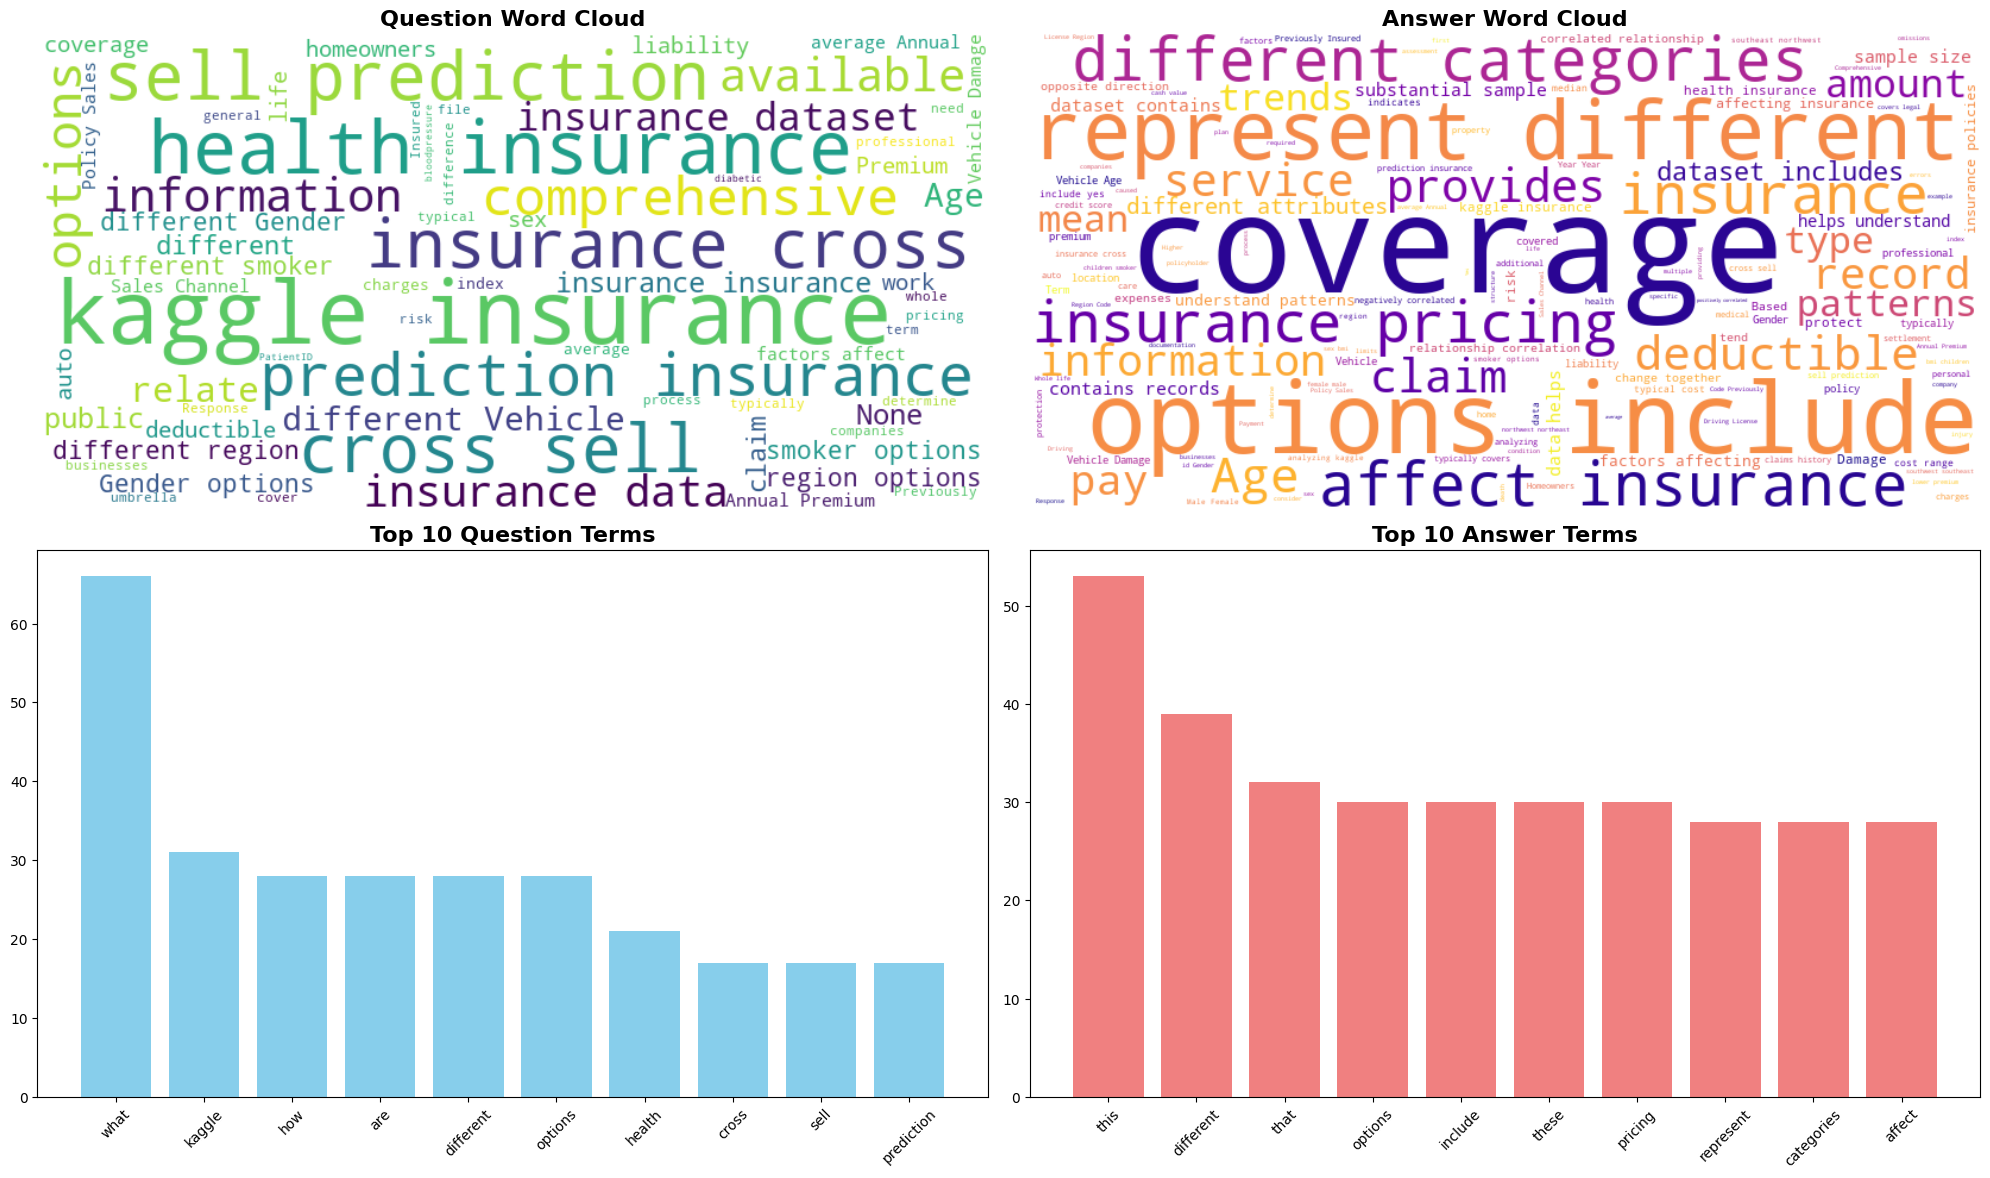


🏢 Insurance Domain Keyword Analysis:
coverage: 66 occurrences
claim: 28 occurrences
premium: 24 occurrences
deductible: 22 occurrences
policy: 20 occurrences
risk: 12 occurrences
liability: 12 occurrences
benefits: 0 occurrences


In [12]:
if comprehensive_df is not None:
    # Text analysis function
    def analyze_insurance_text(text_series, title):
        """Analyze text content specific to insurance domain."""
        all_text = ' '.join(text_series).lower()
        
        # Insurance-specific stop words to remove
        insurance_stopwords = {'insurance', 'policy', 'coverage', 'the', 'and', 'or', 'of', 'to', 'in', 'for', 'with', 'by'}
        
        # Extract meaningful words (3+ characters, not stop words)
        words = re.findall(r'\b[a-z]{3,}\b', all_text)
        words = [word for word in words if word not in insurance_stopwords]
        
        word_freq = Counter(words)
        
        print(f"\n🔍 {title} Analysis:")
        print(f"Total words: {len(words)}")
        print(f"Unique words: {len(word_freq)}")
        print(f"Most common insurance terms: {word_freq.most_common(15)}")
        
        return word_freq
    
    # Analyze questions and answers
    question_words = analyze_insurance_text(comprehensive_df['question'], "Questions")
    answer_words = analyze_insurance_text(comprehensive_df['answer'], "Answers")
    
    # Create word clouds
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    
    # Question word cloud
    question_text = ' '.join(comprehensive_df['question'])
    question_wordcloud = WordCloud(width=800, height=400, background_color='white', 
                                  colormap='viridis').generate(question_text)
    axes[0, 0].imshow(question_wordcloud, interpolation='bilinear')
    axes[0, 0].set_title('Question Word Cloud', fontsize=16, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Answer word cloud
    answer_text = ' '.join(comprehensive_df['answer'])
    answer_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                colormap='plasma').generate(answer_text)
    axes[0, 1].imshow(answer_wordcloud, interpolation='bilinear')
    axes[0, 1].set_title('Answer Word Cloud', fontsize=16, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Top question terms bar chart
    top_q_words = dict(question_words.most_common(10))
    axes[1, 0].bar(top_q_words.keys(), top_q_words.values(), color='skyblue')
    axes[1, 0].set_title('Top 10 Question Terms', fontsize=16, fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Top answer terms bar chart
    top_a_words = dict(answer_words.most_common(10))
    axes[1, 1].bar(top_a_words.keys(), top_a_words.values(), color='lightcoral')
    axes[1, 1].set_title('Top 10 Answer Terms', fontsize=16, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Insurance domain relevance analysis
    insurance_keywords = ['premium', 'claim', 'deductible', 'coverage', 'policy', 'risk', 'liability', 'benefits']
    
    keyword_counts = {}
    for keyword in insurance_keywords:
        count = comprehensive_df['question'].str.lower().str.count(keyword).sum() + \
                comprehensive_df['answer'].str.lower().str.count(keyword).sum()
        keyword_counts[keyword] = count
    
    print("\n🏢 Insurance Domain Keyword Analysis:")
    for keyword, count in sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"{keyword}: {count} occurrences")
else:
    print("❌ No comprehensive dataset available for text analysis")

## 9. Prepare Final Training Dataset

Let's prepare the final dataset for model training in the appropriate format.

In [ ]:
# Enhanced Dataset Exploration Functions

class InsuranceDataExplorer:
    """Comprehensive insurance dataset exploration class."""
    
    def __init__(self, display_available=True):
        self.display_available = display_available
        self.datasets = {}
        self.exploration_results = {}
    
    def load_csv_dataset(self, file_path, dataset_name, category=None):
        """Load and provide comprehensive exploration of CSV dataset."""
        try:
            df = pd.read_csv(file_path)
            
            # Sanitize category
            safe_category = category if (category is not None and str(category).strip() != "") else "Unknown"
            if not isinstance(safe_category, str):
                safe_category = str(safe_category)
            
            print(f"\n📊 Dataset: {dataset_name}")
            print("="*70)
            print(f"📁 File: {file_path.relative_to(DATA_DIR) if isinstance(file_path, Path) else file_path}")
            print(f"🏷️ Category: {safe_category}")
            print(f"📏 Shape: {df.shape}")
            print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
            
            # Basic info
            print(f"\n🔍 Column Information:")
            buffer = []
            buffer.append(f"{'Column':<25} {'Non-Null Count':<15} {'Dtype':<15} {'Unique Values':<15}")
            buffer.append("-" * 70)
            
            for col in df.columns:
                non_null = df[col].count()
                dtype = str(df[col].dtype)
                unique_count = df[col].nunique()
                buffer.append(f"{col:<25} {non_null:<15} {dtype:<15} {unique_count:<15}")
            
            print("\n".join(buffer))
            
            # Missing values analysis
            missing_data = df.isnull().sum()
            if missing_data.any():
                print(f"\n⚠️ Missing Values Analysis:")
                for col, missing_count in missing_data[missing_data > 0].items():
                    missing_pct = (missing_count / len(df)) * 100
                    print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")
            else:
                print(f"\n✅ No missing values found")
            
            # Data types analysis
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
            datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()
            
            print(f"\n📊 Data Types Summary:")
            print(f"  📈 Numeric columns: {len(numeric_cols)}")
            print(f"  📝 Categorical columns: {len(categorical_cols)}")
            print(f"  📅 Datetime columns: {len(datetime_cols)}")
            
            # Display sample data
            print(f"\n🔍 Sample Data (first 3 rows):")
            if self.display_available:
                try:
                    display(df.head(3))
                except:
                    print(df.head(3).to_string())
            else:
                print(df.head(3).to_string())
            
            # Statistical summary for numeric columns
            if numeric_cols:
                print(f"\n📈 Numerical Statistics:")
                if self.display_available:
                    try:
                        display(df[numeric_cols].describe())
                    except:
                        print(df[numeric_cols].describe().to_string())
                else:
                    print(df[numeric_cols].describe().to_string())
            
            # Categorical analysis
            if categorical_cols:
                print(f"\n📝 Categorical Analysis:")
                for col in categorical_cols[:5]:  # Analyze first 5 categorical columns
                    unique_count = df[col].nunique()
                    print(f"\n  {col} ({unique_count} unique values):")
                    
                    if unique_count <= 20:  # Show all values if <= 20
                        value_counts = df[col].value_counts()
                        for value, count in value_counts.head(10).items():
                            percentage = (count / len(df)) * 100
                            bar_length = int((count / value_counts.max()) * 30)
                            bar = "█" * bar_length
                            print(f"    {str(value)[:20]:<20} {bar} {count} ({percentage:.1f}%)")
                    else:
                        print(f"    Too many unique values to display ({unique_count})")
                        # Show top 5 most frequent
                        top_values = df[col].value_counts().head(5)
                        print(f"    Top 5 values: {', '.join(map(str, top_values.index))}")
            
            # Store dataset information
            dataset_info = {
                'dataframe': df,
                'path': file_path,
                'category': safe_category,
                'shape': df.shape,
                'numeric_columns': numeric_cols,
                'categorical_columns': categorical_cols,
                'datetime_columns': datetime_cols,
                'missing_data': missing_data[missing_data > 0].to_dict(),
                'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2
            }
            
            self.datasets[dataset_name] = dataset_info
            return df
            
        except Exception as e:
            print(f"❌ Error loading {file_path}: {str(e)}")
            return None
    
    def detect_insurance_relevance(self, df, dataset_name):
        """Detect insurance-relevant columns and content."""
        insurance_keywords = [
            'premium', 'policy', 'claim', 'coverage', 'deductible', 'insurance',
            'risk', 'liability', 'benefit', 'accident', 'damage', 'injury',
            'medical', 'health', 'auto', 'vehicle', 'home', 'life', 'death',
            'age', 'gender', 'smoker', 'region', 'charges', 'expenses'
        ]
        
        relevance_score = 0
        relevant_columns = []
        
        for col in df.columns:
            col_lower = col.lower()
            # Check column names
            for keyword in insurance_keywords:
                if keyword in col_lower:
                    relevant_columns.append(col)
                    relevance_score += 10
                    break
            
            # Check categorical values for insurance terms
            if df[col].dtype == 'object':
                try:
                    sample_values = df[col].dropna().astype(str).str.lower()
                    for keyword in insurance_keywords:
                        if sample_values.str.contains(keyword, na=False).any():
                            if col not in relevant_columns:
                                relevant_columns.append(col)
                            relevance_score += 5
                            break
                except:
                    pass
        
        print(f"\n🎯 Insurance Relevance Analysis for {dataset_name}:")
        print(f"  📊 Relevance Score: {relevance_score}")
        print(f"  📝 Relevant Columns: {relevant_columns}")
        
        if relevance_score > 20:
            print(f"  ✅ High insurance relevance - suitable for training")
        elif relevance_score > 10:
            print(f"  ⚠️ Moderate insurance relevance - may need preprocessing")
        else:
            print(f"  ❌ Low insurance relevance - consider transformation")
        
        return relevance_score, relevant_columns
    
    def analyze_text_content(self, df, dataset_name):
        """Analyze text content for potential Q&A extraction."""
        text_columns = []
        
        for col in df.columns:
            if df[col].dtype == 'object':
                sample_text = df[col].dropna().head(10).astype(str)
                avg_length = sample_text.str.len().mean()
                
                if avg_length > 50:  # Potential text content
                    text_columns.append({
                        'column': col,
                        'avg_length': avg_length,
                        'max_length': sample_text.str.len().max(),
                        'sample_count': len(sample_text)
                    })
        
        if text_columns:
            print(f"\n💬 Text Content Analysis for {dataset_name}:")
            for text_info in text_columns:
                col = text_info['column']
                print(f"  📄 {col}:")
                print(f"    Average length: {text_info['avg_length']:.1f} characters")
                print(f"    Max length: {text_info['max_length']} characters")
                
                # Show sample
                sample = df[col].dropna().iloc[0] if len(df[col].dropna()) > 0 else "No data"
                print(f"    Sample: {str(sample)[:100]}...")
        
        return text_columns
    
    def generate_summary_report(self):
        """Generate comprehensive summary report."""
        print(f"\n📋 COMPREHENSIVE EXPLORATION SUMMARY")
        print("="*80)
        
        total_datasets = len(self.datasets)
        total_records = sum(info['shape'][0] for info in self.datasets.values())
        total_features = sum(info['shape'][1] for info in self.datasets.values())
        total_memory = sum(info['memory_usage_mb'] for info in self.datasets.values())
        
        print(f"📊 Overall Statistics:")
        print(f"  Total datasets: {total_datasets}")
        print(f"  Total records: {total_records:,}")
        print(f"  Total features: {total_features}")
        print(f"  Total memory usage: {total_memory:.2f} MB")
        
        # Group by category (sanitize None or non-str)
        categories = {}
        for name, info in self.datasets.items():
            raw_cat = info.get('category')
            cat_key = raw_cat if (raw_cat is not None and str(raw_cat).strip() != "") else "Unknown"
            if not isinstance(cat_key, str):
                cat_key = str(cat_key)
            
            if cat_key not in categories:
                categories[cat_key] = []
            categories[cat_key].append(name)
        
        print(f"\n🏷️ Datasets by Category:")
        for cat_key, ds_list in categories.items():
            cat_label = str(cat_key or 'Unknown').replace('_', ' ').title()
            print(f"  {cat_label}: {len(ds_list)} datasets")
            for dataset in ds_list:
                shape = self.datasets[dataset]['shape']
                print(f"    📁 {dataset}: {shape[0]:,} rows × {shape[1]} columns")
        
        return {
            'total_datasets': total_datasets,
            'total_records': total_records,
            'total_features': total_features,
            'categories': categories
        }

# Initialize enhanced explorer
explorer = InsuranceDataExplorer(display_available=DISPLAY_AVAILABLE)

# Load all CSV files with enhanced exploration
print("🔍 ENHANCED DATASET EXPLORATION")
print("="*80)

loaded_datasets = {}

# Explore all CSV files in the organized directory structure
for root, dirs, files in os.walk(RAW_DATA_DIR):
    for file in files:
        if file.endswith('.csv'):
            file_path = Path(root) / file
            
            # Determine category from directory structure
            relative_path = file_path.relative_to(RAW_DATA_DIR)
            category = None
            if len(relative_path.parts) > 1:
                category = relative_path.parts[0]  # First directory name
            
            # Create descriptive dataset name
            dataset_name = f"{category}_{file}" if category else file
            
            # Load and explore dataset
            df = explorer.load_csv_dataset(file_path, dataset_name, category)
            
            if df is not None:
                # Additional insurance-specific analysis
                relevance_score, relevant_cols = explorer.detect_insurance_relevance(df, dataset_name)
                text_columns = explorer.analyze_text_content(df, dataset_name)
                
                loaded_datasets[dataset_name] = {
                    'dataframe': df,
                    'path': file_path,
                    'category': category if (category is not None and str(category).strip() != "") else "Unknown",
                    'relevance_score': relevance_score,
                    'relevant_columns': relevant_cols,
                    'text_columns': text_columns
                }

print(f"\n🎉 Enhanced exploration completed!")
print(f"📊 Successfully analyzed {len(loaded_datasets)} datasets")

# Generate comprehensive summary
summary = explorer.generate_summary_report()

🔍 ENHANCED DATASET EXPLORATION

📊 Dataset: insurance.csv
📁 File: raw\insurance.csv
🏷️ Category: Unknown
📏 Shape: (1338, 7)
💾 Memory usage: 0.28 MB

🔍 Column Information:
Column                    Non-Null Count  Dtype           Unique Values  
----------------------------------------------------------------------
age                       1338            int64           47             
sex                       1338            object          2              
bmi                       1338            float64         548            
children                  1338            int64           6              
smoker                    1338            object          2              
region                    1338            object          4              
charges                   1338            float64         1337           

✅ No missing values found

📊 Data Types Summary:
  📈 Numeric columns: 4
  📝 Categorical columns: 3
  📅 Datetime columns: 0

🔍 Sample Data (first 3 rows):


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620



📈 Numerical Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



📝 Categorical Analysis:

  sex (2 unique values):
    male                 ██████████████████████████████ 676 (50.5%)
    female               █████████████████████████████ 662 (49.5%)

  smoker (2 unique values):
    no                   ██████████████████████████████ 1064 (79.5%)
    yes                  ███████ 274 (20.5%)

  region (4 unique values):
    southeast            ██████████████████████████████ 364 (27.2%)
    southwest            ██████████████████████████ 325 (24.3%)
    northwest            ██████████████████████████ 325 (24.3%)
    northeast            ██████████████████████████ 324 (24.2%)

🎯 Insurance Relevance Analysis for insurance.csv:
  📊 Relevance Score: 40
  📝 Relevant Columns: ['age', 'smoker', 'region', 'charges']
  ✅ High insurance relevance - suitable for training

📊 Dataset: health-insurance-cross-sell-prediction_sample_submission.csv
📁 File: raw\health-insurance-cross-sell-prediction\sample_submission.csv
🏷️ Category: health-insurance-cross-sell-predic

,id,Response
0,381110,0
1,381111,0
2,381112,0



📈 Numerical Statistics:


,id,Response
count,127037.000000,127037.0
mean,444628.000000,0.0
std,36672.567411,0.0
min,381110.000000,0.0
25%,412869.000000,0.0
50%,444628.000000,0.0
75%,476387.000000,0.0
max,508146.000000,0.0



🎯 Insurance Relevance Analysis for health-insurance-cross-sell-prediction_sample_submission.csv:
  📊 Relevance Score: 0
  📝 Relevant Columns: []
  ❌ Low insurance relevance - consider transformation

📊 Dataset: health-insurance-cross-sell-prediction_test.csv
📁 File: raw\health-insurance-cross-sell-prediction\test.csv
🏷️ Category: health-insurance-cross-sell-prediction
📏 Shape: (127037, 11)
💾 Memory usage: 30.35 MB

🔍 Column Information:
Column                    Non-Null Count  Dtype           Unique Values  
----------------------------------------------------------------------
id                        127037          int64           127037         
Gender                    127037          object          2              
Age                       127037          int64           66             
Driving_License           127037          int64           2              
Region_Code               127037          float64         53             
Previously_Insured        127037          i

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199



📈 Numerical Statistics:


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000
mean,444628.000000,38.765903,0.998134,26.459866,0.460039,30524.643576,111.800468,154.318301
std,36672.567411,15.465814,0.043152,13.209916,0.498403,16945.297103,54.371765,83.661588
min,381110.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,412869.000000,25.000000,1.000000,15.000000,0.000000,24325.000000,26.000000,82.000000
50%,444628.000000,36.000000,1.000000,28.000000,0.000000,31642.000000,135.000000,154.000000
75%,476387.000000,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,472042.000000,163.000000,299.000000



📝 Categorical Analysis:

  Gender (2 unique values):
    Male                 ██████████████████████████████ 68236 (53.7%)
    Female               █████████████████████████ 58801 (46.3%)

  Vehicle_Age (3 unique values):
    1-2 Year             ██████████████████████████████ 66699 (52.5%)
    < 1 Year             ████████████████████████ 55019 (43.3%)
    > 2 Years            ██ 5319 (4.2%)

  Vehicle_Damage (2 unique values):
    Yes                  ██████████████████████████████ 63835 (50.2%)
    No                   █████████████████████████████ 63202 (49.8%)

🎯 Insurance Relevance Analysis for health-insurance-cross-sell-prediction_test.csv:
  📊 Relevance Score: 80
  📝 Relevant Columns: ['Gender', 'Age', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
  ✅ High insurance relevance - suitable for training

📊 Dataset: health-insurance-cross-sell-prediction_train.csv
📁 File: raw\health-insurance-cross-sell-prediction\train.csv
🏷️

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1



📈 Numerical Statistics:


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000



📝 Categorical Analysis:

  Gender (2 unique values):
    Male                 ██████████████████████████████ 206089 (54.1%)
    Female               █████████████████████████ 175020 (45.9%)

  Vehicle_Age (3 unique values):
    1-2 Year             ██████████████████████████████ 200316 (52.6%)
    < 1 Year             ████████████████████████ 164786 (43.2%)
    > 2 Years            ██ 16007 (4.2%)

  Vehicle_Damage (2 unique values):
    Yes                  ██████████████████████████████ 192413 (50.5%)
    No                   █████████████████████████████ 188696 (49.5%)

🎯 Insurance Relevance Analysis for health-insurance-cross-sell-prediction_train.csv:
  📊 Relevance Score: 80
  📝 Relevant Columns: ['Gender', 'Age', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
  ✅ High insurance relevance - suitable for training

📊 Dataset: insurance_insurance.csv
📁 File: raw\insurance\insurance.csv
🏷️ Category: insurance
📏 Shape: (1338, 7)
💾 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620



📈 Numerical Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



📝 Categorical Analysis:

  sex (2 unique values):
    male                 ██████████████████████████████ 676 (50.5%)
    female               █████████████████████████████ 662 (49.5%)

  smoker (2 unique values):
    no                   ██████████████████████████████ 1064 (79.5%)
    yes                  ███████ 274 (20.5%)

  region (4 unique values):
    southeast            ██████████████████████████████ 364 (27.2%)
    southwest            ██████████████████████████ 325 (24.3%)
    northwest            ██████████████████████████ 325 (24.3%)
    northeast            ██████████████████████████ 324 (24.2%)

🎯 Insurance Relevance Analysis for insurance_insurance.csv:
  📊 Relevance Score: 40
  📝 Relevant Columns: ['age', 'smoker', 'region', 'charges']
  ✅ High insurance relevance - suitable for training

📊 Dataset: kaggle_insurance_data.csv
📁 File: raw\kaggle\claims_analysis\insurance_data.csv
🏷️ Category: kaggle
📏 Shape: (1340, 11)
💾 Memory usage: 0.39 MB

🔍 Column Information:
Colu

,index,PatientID,age,gender,bmi,bloodpressure,diabetic,children,smoker,region,claim
0,0,1,39.0,male,23.2,91,Yes,0,No,southeast,1121.87
1,1,2,24.0,male,30.1,87,No,0,No,southeast,1131.51
2,2,3,NaN,male,33.3,82,Yes,0,No,southeast,1135.94



📈 Numerical Statistics:


,index,PatientID,age,bmi,bloodpressure,children,claim
count,1340.000000,1340.000000,1335.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,669.500000,670.500000,38.078652,30.668955,94.157463,1.093284,13252.745642
std,386.968991,386.968991,11.102924,6.106735,11.434712,1.205334,12109.609288
min,0.000000,1.000000,18.000000,16.000000,80.000000,0.000000,1121.870000
25%,334.750000,335.750000,29.000000,26.275000,86.000000,0.000000,4719.685000
50%,669.500000,670.500000,38.000000,30.400000,92.000000,1.000000,9369.615000
75%,1004.250000,1005.250000,47.000000,34.700000,99.000000,2.000000,16604.305000
max,1339.000000,1340.000000,60.000000,53.100000,140.000000,5.000000,63770.430000



📝 Categorical Analysis:

  gender (2 unique values):
    male                 ██████████████████████████████ 678 (50.6%)
    female               █████████████████████████████ 662 (49.4%)

  diabetic (2 unique values):
    No                   ██████████████████████████████ 698 (52.1%)
    Yes                  ███████████████████████████ 642 (47.9%)

  smoker (2 unique values):
    No                   ██████████████████████████████ 1066 (79.6%)
    Yes                  ███████ 274 (20.4%)

  region (4 unique values):
    southeast            ██████████████████████████████ 443 (33.1%)
    northwest            ███████████████████████ 349 (26.0%)
    southwest            █████████████████████ 314 (23.4%)
    northeast            ███████████████ 231 (17.2%)

🎯 Insurance Relevance Analysis for kaggle_insurance_data.csv:
  📊 Relevance Score: 50
  📝 Relevant Columns: ['age', 'gender', 'smoker', 'region', 'claim']
  ✅ High insurance relevance - suitable for training

📊 Dataset: kaggle_insura

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620



📈 Numerical Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



📝 Categorical Analysis:

  sex (2 unique values):
    male                 ██████████████████████████████ 676 (50.5%)
    female               █████████████████████████████ 662 (49.5%)

  smoker (2 unique values):
    no                   ██████████████████████████████ 1064 (79.5%)
    yes                  ███████ 274 (20.5%)

  region (4 unique values):
    southeast            ██████████████████████████████ 364 (27.2%)
    southwest            ██████████████████████████ 325 (24.3%)
    northwest            ██████████████████████████ 325 (24.3%)
    northeast            ██████████████████████████ 324 (24.2%)

🎯 Insurance Relevance Analysis for kaggle_insurance.csv:
  📊 Relevance Score: 40
  📝 Relevant Columns: ['age', 'smoker', 'region', 'charges']
  ✅ High insurance relevance - suitable for training

📊 Dataset: kaggle_insurance.csv
📁 File: raw\kaggle\premium_prediction\insurance.csv
🏷️ Category: kaggle
📏 Shape: (1338, 7)
💾 Memory usage: 0.28 MB

🔍 Column Information:
Column         

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46



📈 Numerical Statistics:


,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000



📝 Categorical Analysis:

  sex (2 unique values):
    male                 ██████████████████████████████ 676 (50.5%)
    female               █████████████████████████████ 662 (49.5%)

  smoker (2 unique values):
    no                   ██████████████████████████████ 1064 (79.5%)
    yes                  ███████ 274 (20.5%)

  region (4 unique values):
    southeast            ██████████████████████████████ 364 (27.2%)
    southwest            ██████████████████████████ 325 (24.3%)
    northwest            ██████████████████████████ 325 (24.3%)
    northeast            ██████████████████████████ 324 (24.2%)

🎯 Insurance Relevance Analysis for kaggle_insurance.csv:
  📊 Relevance Score: 40
  📝 Relevant Columns: ['age', 'smoker', 'region', 'expenses']
  ✅ High insurance relevance - suitable for training

📊 Dataset: kaggle_sample_submission.csv
📁 File: raw\kaggle\vehicle_insurance\sample_submission.csv
🏷️ Category: kaggle
📏 Shape: (127037, 2)
💾 Memory usage: 1.94 MB

🔍 Column Informatio

,id,Response
0,381110,0
1,381111,0
2,381112,0



📈 Numerical Statistics:


,id,Response
count,127037.000000,127037.0
mean,444628.000000,0.0
std,36672.567411,0.0
min,381110.000000,0.0
25%,412869.000000,0.0
50%,444628.000000,0.0
75%,476387.000000,0.0
max,508146.000000,0.0



🎯 Insurance Relevance Analysis for kaggle_sample_submission.csv:
  📊 Relevance Score: 0
  📝 Relevant Columns: []
  ❌ Low insurance relevance - consider transformation

📊 Dataset: kaggle_test.csv
📁 File: raw\kaggle\vehicle_insurance\test.csv
🏷️ Category: kaggle
📏 Shape: (127037, 11)
💾 Memory usage: 30.35 MB

🔍 Column Information:
Column                    Non-Null Count  Dtype           Unique Values  
----------------------------------------------------------------------
id                        127037          int64           127037         
Gender                    127037          object          2              
Age                       127037          int64           66             
Driving_License           127037          int64           2              
Region_Code               127037          float64         53             
Previously_Insured        127037          int64           2              
Vehicle_Age               127037          object          3              
Vehic

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199



📈 Numerical Statistics:


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
count,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000,127037.000000
mean,444628.000000,38.765903,0.998134,26.459866,0.460039,30524.643576,111.800468,154.318301
std,36672.567411,15.465814,0.043152,13.209916,0.498403,16945.297103,54.371765,83.661588
min,381110.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,412869.000000,25.000000,1.000000,15.000000,0.000000,24325.000000,26.000000,82.000000
50%,444628.000000,36.000000,1.000000,28.000000,0.000000,31642.000000,135.000000,154.000000
75%,476387.000000,49.000000,1.000000,35.000000,1.000000,39408.000000,152.000000,227.000000
max,508146.000000,85.000000,1.000000,52.000000,1.000000,472042.000000,163.000000,299.000000



📝 Categorical Analysis:

  Gender (2 unique values):
    Male                 ██████████████████████████████ 68236 (53.7%)
    Female               █████████████████████████ 58801 (46.3%)

  Vehicle_Age (3 unique values):
    1-2 Year             ██████████████████████████████ 66699 (52.5%)
    < 1 Year             ████████████████████████ 55019 (43.3%)
    > 2 Years            ██ 5319 (4.2%)

  Vehicle_Damage (2 unique values):
    Yes                  ██████████████████████████████ 63835 (50.2%)
    No                   █████████████████████████████ 63202 (49.8%)

🎯 Insurance Relevance Analysis for kaggle_test.csv:
  📊 Relevance Score: 80
  📝 Relevant Columns: ['Gender', 'Age', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
  ✅ High insurance relevance - suitable for training

📊 Dataset: kaggle_train.csv
📁 File: raw\kaggle\vehicle_insurance\train.csv
🏷️ Category: kaggle
📏 Shape: (381109, 12)
💾 Memory usage: 93.94 MB

🔍 Column Inf

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1



📈 Numerical Statistics:


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000



📝 Categorical Analysis:

  Gender (2 unique values):
    Male                 ██████████████████████████████ 206089 (54.1%)
    Female               █████████████████████████ 175020 (45.9%)

  Vehicle_Age (3 unique values):
    1-2 Year             ██████████████████████████████ 200316 (52.6%)
    < 1 Year             ████████████████████████ 164786 (43.2%)
    > 2 Years            ██ 16007 (4.2%)

  Vehicle_Damage (2 unique values):
    Yes                  ██████████████████████████████ 192413 (50.5%)
    No                   █████████████████████████████ 188696 (49.5%)

🎯 Insurance Relevance Analysis for kaggle_train.csv:
  📊 Relevance Score: 80
  📝 Relevant Columns: ['Gender', 'Age', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
  ✅ High insurance relevance - suitable for training

📊 Dataset: public_insurance_medical_cost.csv
📁 File: raw\public\health_insurance\insurance_medical_cost.csv
🏷️ Category: public
📏 Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620



📈 Numerical Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010



📝 Categorical Analysis:

  sex (2 unique values):
    male                 ██████████████████████████████ 676 (50.5%)
    female               █████████████████████████████ 662 (49.5%)

  smoker (2 unique values):
    no                   ██████████████████████████████ 1064 (79.5%)
    yes                  ███████ 274 (20.5%)

  region (4 unique values):
    southeast            ██████████████████████████████ 364 (27.2%)
    southwest            ██████████████████████████ 325 (24.3%)
    northwest            ██████████████████████████ 325 (24.3%)
    northeast            ██████████████████████████ 324 (24.2%)

🎯 Insurance Relevance Analysis for public_insurance_medical_cost.csv:
  📊 Relevance Score: 40
  📝 Relevant Columns: ['age', 'smoker', 'region', 'charges']
  ✅ High insurance relevance - suitable for training

🎉 Enhanced exploration completed!
📊 Successfully analyzed 11 datasets

📋 COMPREHENSIVE EXPLORATION SUMMARY
📊 Overall Statistics:
  Total datasets: 11
  Total records: 1,277

: 

## 10. Next Steps

Your real insurance dataset is now ready! Here's what you can do next:

1. **Start Fine-tuning**: Use the prepared datasets with the fine-tuning notebook
2. **Explore More Data**: Add more Kaggle datasets or domain-specific sources
3. **Data Augmentation**: Generate synthetic Q&A pairs using GPT models
4. **Quality Improvement**: Manual review and curation of the dataset

The datasets are saved in the `../data/processed/` directory and ready for use with the fine-tuning pipeline!

## 11. Start Fine-tuning (Quick Start)

This section fine-tunes a small model (FLAN-T5-small) on the prepared Q&A splits for a quick end-to-end run. It limits samples to keep runtime short. You can scale up later.

In [ ]:
# Quick Fine-tuning on Prepared Splits (Lightweight)
# Notes:
# - Uses a small model to keep memory/time low.
# - Trains on a subset (e.g., 500 train, 100 val) for a fast first run.
# - Saves model to ../models/quickstart.

import json
from pathlib import Path

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Trainer, TrainingArguments

PROCESSED_DIR = PROCESSED_DATA_DIR / "training_data"
MODEL_DIR = Path("../models/quickstart")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Load splits
with open(PROCESSED_DIR / "insurance_qa_train.json", "r", encoding="utf-8") as f:
    train_data = json.load(f)
with open(PROCESSED_DIR / "insurance_qa_validation.json", "r", encoding="utf-8") as f:
    val_data = json.load(f)

# Subsample for speed
train_data = train_data[:500]
val_data = val_data[:100]

# Convert to HF Datasets
ds_train = Dataset.from_list(train_data)
ds_val = Dataset.from_list(val_data)

# Use a small seq2seq model
model_name = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Preprocess
max_input_length = 256
max_target_length = 256

def preprocess(example):
    # Prompt style: Question → Answer
    input_text = "Question: " + example["question"] + "\nAnswer:"
    target_text = example["answer"]
    model_inputs = tokenizer(
        input_text,
        max_length=max_input_length,
        truncation=True
    )
    labels = tokenizer(
        target_text,
        max_length=max_target_length,
        truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

proc_train = ds_train.map(preprocess)
proc_val = ds_val.map(preprocess)

collator = DataCollatorForSeq2Seq(tokenizer, model=model)

args = TrainingArguments(
    output_dir=str(MODEL_DIR),
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=5e-5,
    num_train_epochs=1,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=200,
    logging_steps=50,
    save_total_limit=1,
    report_to=[],  # disable wandb/etc
    fp16=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=proc_train,
    eval_dataset=proc_val,
    data_collator=collator,
    tokenizer=tokenizer,
)

trainer.train()

trainer.save_model(str(MODEL_DIR))
print(f"✅ Quickstart model saved to: {MODEL_DIR}")

In [ ]:
# Quick Evaluation on Validation Samples
from transformers import pipeline

pipe = pipeline("text2text-generation", model=str(MODEL_DIR), tokenizer=str(MODEL_DIR))

print("\n🔎 Quick sanity check on a few validation questions:")
for i in range(3):
    ex = val_data[i]
    prompt = "Question: " + ex["question"] + "\nAnswer:"
    out = pipe(prompt, max_new_tokens=128, do_sample=False)[0]["generated_text"].strip()
    print(f"\nQ: {ex['question']}")
    print(f"Pred: {out[:300]}")
    print(f"Ref:  {ex['answer'][:300]}")